In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

# Import API keys from config
from config import BINANCE_API_KEY, BINANCE_API_SECRET
    
# Initialize Binance client
client = Client(BINANCE_API_KEY, BINANCE_API_SECRET)
print("Binance client initialized successfully")

Binance client initialized successfully


In [14]:
def get_top_50_crypto_assets():
    """
    Get the top 50 largest cryptocurrency assets by 24hr volume from Binance.
    
    Returns:
        pandas.DataFrame: DataFrame containing symbol, price, volume, and other metrics
    """
    try:
        # Get 24hr ticker statistics for all symbols
        tickers = client.get_ticker()
        
        # Convert to DataFrame
        df = pd.DataFrame(tickers)
        
        # Filter for USDT pairs only (most liquid and representative)
        usdt_pairs = df[df['symbol'].str.endswith('USDT')].copy()
        
        # Convert numeric columns
        numeric_cols = ['priceChange', 'priceChangePercent', 'weightedAvgPrice', 
                       'prevClosePrice', 'lastPrice', 'bidPrice', 'askPrice', 
                       'openPrice', 'highPrice', 'lowPrice', 'volume', 'quoteVolume']
        
        for col in numeric_cols:
            if col in usdt_pairs.columns:
                usdt_pairs[col] = pd.to_numeric(usdt_pairs[col], errors='coerce')
        
        # Sort by quote volume (USD volume) and get top 50
        top_50 = usdt_pairs.nlargest(50, 'quoteVolume').copy()
        
        # Add a clean symbol name (remove USDT suffix)
        top_50['base_asset'] = top_50['symbol'].str.replace('USDT', '')
        
        # Select relevant columns
        result_df = top_50[['symbol', 'base_asset', 'lastPrice', 'priceChangePercent', 
                           'volume', 'quoteVolume', 'highPrice', 'lowPrice']].copy()
        
        # Rename columns for clarity
        result_df.columns = ['Symbol', 'Base_Asset', 'Last_Price', 'Price_Change_24h_Pct', 
                            'Volume_24h', 'Quote_Volume_24h_USD', 'High_24h', 'Low_24h']
        
        # Reset index
        result_df.reset_index(drop=True, inplace=True)
        
        print(f"Successfully retrieved top 50 crypto assets by 24hr volume")
        print(f"Total quote volume (USD): ${result_df['Quote_Volume_24h_USD'].sum():,.0f}")
        
        return result_df
        
    except Exception as e:
        print(f"Error retrieving top crypto assets: {e}")
        return pd.DataFrame()

# Test the function
top_50_crypto = get_top_50_crypto_assets()
print(f"\nTop 10 crypto assets by volume:")
print(top_50_crypto.head(10)[['Symbol', 'Base_Asset', 'Last_Price', 'Quote_Volume_24h_USD']])

Successfully retrieved top 50 crypto assets by 24hr volume
Total quote volume (USD): $2,734,715,754

Top 10 crypto assets by volume:
      Symbol Base_Asset     Last_Price  Quote_Volume_24h_USD
0    BTCUSDT        BTC  108195.990000          4.569599e+08
1    ETHUSDT        ETH    2457.360000          3.843545e+08
2    SOLUSDT        SOL     151.490000          3.105022e+08
3   USDCUSDT       USDC       0.999600          2.438624e+08
4  PENGUUSDT      PENGU       0.013234          9.937339e+07
5  FDUSDUSDT      FDUSD       0.998100          9.931852e+07
6    XRPUSDT        XRP       2.194700          8.854906e+07
7    SUIUSDT        SUI       2.827600          7.911608e+07
8    SEIUSDT        SEI       0.304800          7.303300e+07
9   PEPEUSDT       PEPE       0.000010          6.000087e+07


In [15]:
def get_crypto_kline_data(symbol, interval='1d', lookback_days=365):
    """
    Get historical kline (candlestick) data for a cryptocurrency from Binance.
    
    Parameters:
        symbol (str): Trading pair symbol (e.g., 'BTCUSDT')
        interval (str): Kline interval ('1m', '5m', '15m', '30m', '1h', '4h', '1d', '1w', '1M')
        lookback_days (int): Number of days to look back from current date
        limit (int): Maximum number of klines to return (max 1000)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data and timestamps
    """
    try:
        # Calculate start time
        end_time = datetime.now()
        start_time = end_time - timedelta(days=lookback_days)
        
        # Convert to timestamp strings
        start_str = str(int(start_time.timestamp() * 1000))
        end_str = str(int(end_time.timestamp() * 1000))
        
        # Get kline data
        klines = client.get_historical_klines(
            symbol=symbol,
            interval=interval,
            start_str=start_str,
            end_str=end_str,
        )
        
        if not klines:
            print(f"No data found for {symbol}")
            return pd.DataFrame()
        
        # Convert to DataFrame
        df = pd.DataFrame(klines, columns=[
            'Open_time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close_time', 'Quote_asset_volume', 'Number_of_trades',
            'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
        ])
        
        # Convert timestamp to datetime
        df['Date'] = pd.to_datetime(df['Open_time'], unit='ms')
        df['Close_Date'] = pd.to_datetime(df['Close_time'], unit='ms')
        
        # Convert price and volume columns to numeric
        price_volume_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote_asset_volume']
        for col in price_volume_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Select and reorder columns
        final_df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Quote_asset_volume']].copy()
        
        # Add symbol information
        final_df['Symbol'] = symbol
        final_df['Base_Asset'] = symbol.replace('USDT', '') if symbol.endswith('USDT') else symbol
        
        # Sort by date
        final_df.sort_values('Date', inplace=True)
        final_df.reset_index(drop=True, inplace=True)
        
        print(f"Retrieved {len(final_df)} klines for {symbol} ({interval} interval)")
        print(f"Date range: {final_df['Date'].min().date()} to {final_df['Date'].max().date()}")
        
        return final_df
        
    except Exception as e:
        print(f"Error retrieving kline data for {symbol}: {e}")
        return pd.DataFrame()

# Test the function with Bitcoin
btc_data = get_crypto_kline_data('BTCUSDT', interval='1d', lookback_days=2000)
print(f"\nBTC data preview:")
print(btc_data.head())

Retrieved 2000 klines for BTCUSDT (1d interval)
Date range: 2020-01-08 to 2025-06-29

BTC data preview:
        Date     Open     High      Low    Close         Volume  \
0 2020-01-08  8145.92  8455.00  7870.00  8055.98  112622.642640   
1 2020-01-09  8054.72  8055.96  7750.00  7817.76   64239.519830   
2 2020-01-10  7817.74  8199.00  7672.00  8197.02   82406.777448   
3 2020-01-11  8198.86  8286.34  8003.16  8020.01   54810.032667   
4 2020-01-12  8020.01  8197.00  7960.00  8184.98   38131.494336   

   Quote_asset_volume   Symbol Base_Asset  
0        9.264102e+08  BTCUSDT        BTC  
1        5.072583e+08  BTCUSDT        BTC  
2        6.527742e+08  BTCUSDT        BTC  
3        4.450343e+08  BTCUSDT        BTC  
4        3.093519e+08  BTCUSDT        BTC  


In [16]:
def get_multiple_crypto_data(symbols_list, interval='1d', lookback_days=365, delay=0.1):
    """
    Get historical kline data for multiple cryptocurrency symbols.
    
    Parameters:
        symbols_list (list): List of trading pair symbols
        interval (str): Kline interval
        lookback_days (int): Number of days to look back
        delay (float): Delay between API calls in seconds to avoid rate limits
    
    Returns:
        dict: Dictionary with symbol as key and DataFrame as value
    """
    crypto_data = {}
    failed_symbols = []
    
    print(f"Fetching historical data for {len(symbols_list)} crypto assets...")
    print(f"Interval: {interval}, Lookback: {lookback_days} days")
    print("-" * 60)
    
    for i, symbol in enumerate(symbols_list, 1):
        try:
            print(f"[{i}/{len(symbols_list)}] Fetching {symbol}...", end=" ")
            
            # Get the data
            df = get_crypto_kline_data(
                symbol=symbol, 
                interval=interval, 
                lookback_days=lookback_days
            )
            
            if not df.empty:
                crypto_data[symbol] = df
                print("✓ Success")
            else:
                failed_symbols.append(symbol)
                print("✗ No data")
            
            # Rate limiting delay
            if delay > 0:
                time.sleep(delay)
                
        except Exception as e:
            failed_symbols.append(symbol)
            print(f"✗ Error: {e}")
            
        # Add a longer delay every 10 requests to be safe with rate limits
        if i % 10 == 0:
            print(f"Processed {i} symbols. Waiting 2 seconds...")
            time.sleep(2)
    
    print("-" * 60)
    print(f"Successfully retrieved data for {len(crypto_data)} out of {len(symbols_list)} symbols")
    
    if failed_symbols:
        print(f"Failed symbols: {failed_symbols}")
    
    return crypto_data

# Example: Get historical data for top 10 crypto assets
if not top_50_crypto.empty:
    top_10_symbols = top_50_crypto['Symbol'].tolist()
    print(f"Getting historical data for top 10 crypto assets:")
    print(top_10_symbols)
    
    # Get the data (using smaller lookback for demo)
    crypto_historical_data = get_multiple_crypto_data(
        symbols_list=top_10_symbols,
        interval='1d',
        lookback_days=2000,  # Last 30 days for demo
        delay=0.1  # 200ms delay between requests
    )
    
    # Display summary
    print(f"\nData Summary:")
    for symbol, df in crypto_historical_data.items():
        if not df.empty:
            latest_price = df['Close'].iloc[-1]
            price_change = ((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100
            print(f"{symbol}: {len(df)} days, Latest: ${latest_price:.2f}, Change: {price_change:.2f}%")
else:
    print("Please run the previous cell to get top 50 crypto assets first.")

Getting historical data for top 10 crypto assets:
['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'USDCUSDT', 'PENGUUSDT', 'FDUSDUSDT', 'XRPUSDT', 'SUIUSDT', 'SEIUSDT', 'PEPEUSDT', 'SAHARAUSDT', 'NEWTUSDT', 'UNIUSDT', 'DOGEUSDT', 'BNBUSDT', 'TRXUSDT', 'WIFUSDT', 'ADAUSDT', 'SYRUPUSDT', 'BANANAS31USDT', 'PNUTUSDT', 'LPTUSDT', 'AAVEUSDT', 'VIRTUALUSDT', 'FUNUSDT', 'NEIROUSDT', 'WUSDT', 'ENAUSDT', 'APTUSDT', 'LTCUSDT', 'BCHUSDT', 'AVAXUSDT', 'LINKUSDT', 'TRUMPUSDT', 'BONKUSDT', 'RESOLVUSDT', '1000CATUSDT', 'BROCCOLI714USDT', 'NEARUSDT', 'WLDUSDT', 'TAOUSDT', 'KAITOUSDT', 'MUBARAKUSDT', 'HBARUSDT', 'CTKUSDT', 'ARBUSDT', 'BSWUSDT', 'OMUSDT', 'FETUSDT', 'ETHFIUSDT']
Fetching historical data for 50 crypto assets...
Interval: 1d, Lookback: 2000 days
------------------------------------------------------------
[1/50] Fetching BTCUSDT... Retrieved 2000 klines for BTCUSDT (1d interval)
Date range: 2020-01-08 to 2025-06-29
✓ Success
[2/50] Fetching ETHUSDT... Retrieved 2000 klines for BTCUSDT (1d interval)
Date

In [17]:
df

,Date,Open,High,Low,Close,Volume,Quote_asset_volume,Symbol,Base_Asset
0,2024-03-18,0.230,5.320,0.230,3.120,66158253.0,2.415231e+08,ETHFIUSDT,ETHFI
1,2024-03-19,3.119,3.486,2.810,3.021,36561527.7,1.143053e+08,ETHFIUSDT,ETHFI
2,2024-03-20,3.021,4.390,2.896,4.207,69007806.1,2.576233e+08,ETHFIUSDT,ETHFI
3,2024-03-21,4.209,4.438,3.705,3.815,37832869.9,1.543784e+08,ETHFIUSDT,ETHFI
4,2024-03-22,3.816,4.160,3.508,3.690,26583233.8,1.006504e+08,ETHFIUSDT,ETHFI
...,...,...,...,...,...,...,...,...,...
464,2025-06-25,0.984,0.993,0.913,0.920,13082417.1,1.244182e+07,ETHFIUSDT,ETHFI
465,2025-06-26,0.921,0.987,0.892,0.926,18068148.6,1.685802e+07,ETHFIUSDT,ETHFI
466,2025-06-27,0.927,0.948,0.877,0.898,12820541.6,1.171737e+07,ETHFIUSDT,ETHFI
467,2025-06-28,0.898,0.933,0.882,0.920,7072509.7,6.377900e+06,ETHFIUSDT,ETHFI


In [18]:
# Show available symbols and the number of rows for each
summary = pd.DataFrame({
	'Symbol': list(crypto_historical_data.keys()),
	'Rows': [df.shape[0] for df in crypto_historical_data.values()],
	'Columns': [df.shape[1] for df in crypto_historical_data.values()]
})
summary

,Symbol,Rows,Columns
0,BTCUSDT,2000,9
1,ETHUSDT,2000,9
2,SOLUSDT,1784,9
3,USDCUSDT,1835,9
4,PENGUUSDT,195,9
5,FDUSDUSDT,705,9
6,XRPUSDT,2000,9
7,SUIUSDT,789,9
8,SEIUSDT,685,9
9,PEPEUSDT,787,9


In [19]:
def combine_crypto_data(crypto_data_dict, price_column='Close'):
    """
    Combine multiple crypto DataFrames into a single DataFrame with symbols as columns.
    
    Parameters:
        crypto_data_dict (dict): Dictionary of symbol -> DataFrame
        price_column (str): Which price column to use ('Open', 'High', 'Low', 'Close')
    
    Returns:
        pandas.DataFrame: Combined DataFrame with Date as index and symbols as columns
    """
    if not crypto_data_dict:
        print("No data to combine")
        return pd.DataFrame()
    
    combined_data = {}
    
    for symbol, df in crypto_data_dict.items():
        if not df.empty and price_column in df.columns:
            # Use Date as index and the specified price column as values
            temp_df = df.set_index('Date')[price_column]
            combined_data[symbol] = temp_df
    
    if combined_data:
        result_df = pd.DataFrame(combined_data)
        result_df.index.name = 'Date'
        
        print(f"Combined data shape: {result_df.shape}")
        print(f"Date range: {result_df.index.min().date()} to {result_df.index.max().date()}")
        
        return result_df
    else:
        print("No valid data to combine")
        return pd.DataFrame()

def export_crypto_data(crypto_data_dict, filename_prefix='crypto_data'):
    """
    Export crypto data to CSV files.
    
    Parameters:
        crypto_data_dict (dict): Dictionary of symbol -> DataFrame
        filename_prefix (str): Prefix for the output files
    """
    if not crypto_data_dict:
        print("No data to export")
        return
    
    # Export individual symbol data
    for symbol, df in crypto_data_dict.items():
        if not df.empty:
            filename = f"{filename_prefix}_{symbol}.csv"
            df.to_csv(filename, index=False)
            print(f"Exported {symbol} data to {filename}")
    
    # Export combined data
    combined_df = combine_crypto_data(crypto_data_dict)
    if not combined_df.empty:
        combined_filename = f"{filename_prefix}_combined_close.csv"
        combined_df.to_csv(combined_filename)
        print(f"Exported combined close prices to {combined_filename}")

# Example usage and data analysis
if 'crypto_historical_data' in locals() and crypto_historical_data:
    print("=== DATA ANALYSIS EXAMPLES ===")
    
    # 1. Combine close prices
    combined_prices = combine_crypto_data(crypto_historical_data, 'Close')
    if not combined_prices.empty:
        print(f"\nCombined close prices preview:")
        print(combined_prices.tail())
        
        # 2. Calculate correlations
        correlations = combined_prices.corr()
        print(f"\nCorrelation matrix (top 5x5):")
        print(correlations.iloc[:5, :5].round(3))
        
        # 3. Calculate daily returns
        daily_returns = combined_prices.pct_change().dropna()
        print(f"\nDaily returns statistics:")
        print(daily_returns.describe().round(4))
        
        # 4. Volatility analysis
        volatility = daily_returns.std() * np.sqrt(365)  # Annualized volatility
        print(f"\nAnnualized volatility (sorted):")
        print(volatility.sort_values(ascending=False).round(4))
        
    print(f"\n=== EXPORT OPTIONS ===")
    print("To export the data, run:")
    print("export_crypto_data(crypto_historical_data, 'my_crypto_analysis')")
else:
    print("No crypto data available. Please run the previous cells first.")

=== DATA ANALYSIS EXAMPLES ===
Combined data shape: (2000, 50)
Date range: 2020-01-08 to 2025-06-29

Combined close prices preview:
              BTCUSDT  ETHUSDT  SOLUSDT  USDCUSDT  PENGUUSDT  FDUSDUSDT  \
Date                                                                      
2025-06-25  107340.58  2418.49   143.57    0.9995   0.009673     0.9983   
2025-06-26  106947.06  2415.96   139.06    0.9995   0.009186     0.9981   
2025-06-27  107047.59  2423.17   142.09    0.9996   0.010753     0.9980   
2025-06-28  107296.79  2435.62   150.72    0.9996   0.013911     0.9979   
2025-06-29  108196.00  2457.35   151.48    0.9996   0.013239     0.9981   

            XRPUSDT  SUIUSDT  SEIUSDT  PEPEUSDT  ...  TAOUSDT  KAITOUSDT  \
Date                                             ...                       
2025-06-25   2.1859   2.7316   0.2798  0.000009  ...    323.3     1.4124   
2025-06-26   2.1054   2.6012   0.2562  0.000009  ...    319.7     1.3584   
2025-06-27   2.1419   2.7213   0.2894 

In [20]:
# Compute the correlation matrix for daily returns
corr_matrix = daily_returns.corr()

# Unstack the matrix, drop self-correlations and duplicate pairs
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.drop_duplicates().sort_values(ascending=False)

# Show the top 10 most correlated pairs
print("Top 10 most correlated asset pairs:")
print(corr_pairs.head(10))

# Show the top 10 least correlated pairs
print("\nTop 10 least correlated asset pairs:")
print(corr_pairs.tail(10))

Top 10 most correlated asset pairs:
WUSDT        LTCUSDT            1.000000
PNUTUSDT     WLDUSDT            0.999999
FUNUSDT      BROCCOLI714USDT    0.999999
TRUMPUSDT    KAITOUSDT          0.999997
ENAUSDT      BONKUSDT           0.999987
KAITOUSDT    ARBUSDT            0.999987
SAHARAUSDT   CTKUSDT            0.999987
DOGEUSDT     LINKUSDT           0.999973
TRUMPUSDT    ARBUSDT            0.999970
VIRTUALUSDT  BSWUSDT            0.999906
dtype: float64

Top 10 least correlated asset pairs:
ADAUSDT     OMUSDT      -0.999811
LPTUSDT     BONKUSDT    -0.999834
NEWTUSDT    KAITOUSDT   -0.999859
            TRUMPUSDT   -0.999899
SEIUSDT     BSWUSDT     -0.999942
SAHARAUSDT  HBARUSDT    -0.999961
HBARUSDT    CTKUSDT     -0.999993
ENAUSDT     TAOUSDT     -0.999996
BONKUSDT    TAOUSDT     -0.999997
SOLUSDT     AAVEUSDT    -0.999999
dtype: float64


In [21]:
# Get volume data and normalize each symbol independently
volumes = combine_crypto_data(crypto_historical_data, 'Volume')

# Normalize each symbol's volume independently (column-wise normalization)
# This prevents symbols with large volumes from dominating the analysis
normalized_volumes = volumes.copy()

for symbol in volumes.columns:
    symbol_volumes = volumes[symbol].dropna()
    if len(symbol_volumes) > 0:
        # Min-max normalization for each symbol independently
        min_vol = symbol_volumes.min()
        max_vol = symbol_volumes.max()
        
        if max_vol > min_vol:  # Avoid division by zero
            normalized_volumes[symbol] = (volumes[symbol] - min_vol) / (max_vol - min_vol)
        else:
            normalized_volumes[symbol] = 0  # All values are the same

print("Volume normalization completed - each symbol normalized independently")
print(f"Original volume ranges:")
for symbol in volumes.columns:
    symbol_volumes = volumes[symbol].dropna()
    if len(symbol_volumes) > 0:
        print(f"  {symbol}: {symbol_volumes.min():,.0f} to {symbol_volumes.max():,.0f}")

print(f"\nNormalized volumes (all should be 0.0 to 1.0):")
for symbol in normalized_volumes.columns:
    symbol_normalized = normalized_volumes[symbol].dropna()
    if len(symbol_normalized) > 0:
        print(f"  {symbol}: {symbol_normalized.min():.3f} to {symbol_normalized.max():.3f}")

normalized_volumes

Combined data shape: (2000, 50)
Date range: 2020-01-08 to 2025-06-29
Volume normalization completed - each symbol normalized independently
Original volume ranges:
  BTCUSDT: 2,637 to 760,705
  ETHUSDT: 58,520 to 4,663,240
  SOLUSDT: 478,921 to 34,965,021
  USDCUSDT: 3,773,660 to 4,188,208,959
  PENGUUSDT: 424,326,870 to 14,586,458,581
  FDUSDUSDT: 66,145 to 5,104,295,418
  XRPUSDT: 15,488,791 to 8,608,358,083
  SUIUSDT: 6,298,802 to 446,598,493
  SEIUSDT: 14,647,053 to 1,320,092,045
  PEPEUSDT: 2,878,357,312,569 to 254,270,289,671,127
  SAHARAUSDT: 319,004,155 to 1,488,278,331
  NEWTUSDT: 79,047,648 to 321,891,756
  UNIUSDT: 260,961 to 167,667,907
  DOGEUSDT: 49,775,170 to 109,073,693,231
  BNBUSDT: 31,276 to 20,188,858
  TRXUSDT: 58,812,403 to 14,514,073,978
  WIFUSDT: 17,193,025 to 499,988,368
  ADAUSDT: 18,121,236 to 2,261,842,102
  SYRUPUSDT: 20,710,078 to 168,445,021
  BANANAS31USDT: 68,455,564 to 7,778,914,736
  PNUTUSDT: 50,836,984 to 2,229,529,936
  LPTUSDT: 18,088 to 27,023,77

,BTCUSDT,ETHUSDT,SOLUSDT,USDCUSDT,PENGUUSDT,FDUSDUSDT,XRPUSDT,SUIUSDT,SEIUSDT,PEPEUSDT,...,TAOUSDT,KAITOUSDT,MUBARAKUSDT,HBARUSDT,CTKUSDT,ARBUSDT,BSWUSDT,OMUSDT,FETUSDT,ETHFIUSDT
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08,0.145087,0.111179,NaN,0.001849,NaN,NaN,0.015521,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003924,NaN,NaN,NaN,NaN,0.060339,NaN
2020-01-09,0.081263,0.066792,NaN,0.000386,NaN,NaN,0.006983,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003423,NaN,NaN,NaN,NaN,0.055742,NaN
2020-01-10,0.105228,0.076201,NaN,0.002357,NaN,NaN,0.015098,NaN,NaN,NaN,...,NaN,NaN,NaN,0.005638,NaN,NaN,NaN,NaN,0.018759,NaN
2020-01-11,0.068824,0.067286,NaN,0.000337,NaN,NaN,0.012074,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004415,NaN,NaN,NaN,NaN,0.099001,NaN
2020-01-12,0.046823,0.037141,NaN,0.000019,NaN,NaN,0.006427,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001535,NaN,NaN,NaN,NaN,0.113775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-25,0.018553,0.077393,0.050881,0.237477,0.150825,0.060124,0.008855,0.099284,0.500649,0.049390,...,0.144638,0.005076,0.159563,0.018180,0.093515,0.137264,0.022878,0.026018,0.039996,0.088986
2025-06-26,0.010470,0.087993,0.059258,0.259034,0.110662,0.049337,0.012207,0.110063,0.278429,0.047777,...,0.116240,0.001973,0.060620,0.028073,0.172627,0.126499,1.000000,0.023907,0.039682,0.134014
2025-06-27,0.012658,0.070136,0.057789,0.305732,0.218288,0.059284,0.012230,0.115464,0.351224,0.033647,...,0.075962,0.000871,0.068830,0.018401,0.043542,0.093833,0.257821,0.023706,0.043020,0.086621


In [22]:
# Analyze trading volume by day of the week using normalized data
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_volume_by_weekday_normalized(crypto_data_dict, use_normalized=True):
    """
    Analyze which day of the week has the highest average trading volume
    Uses normalized volumes to prevent large volume symbols from dominating
    
    Parameters:
        crypto_data_dict (dict): Dictionary of symbol -> DataFrame
        use_normalized (bool): Whether to normalize each symbol's volume independently
    
    Returns:
        pandas.DataFrame: Summary of volume statistics by weekday
    """
    all_volume_data = []
    
    # Collect volume data from all cryptocurrencies
    for symbol, df in crypto_data_dict.items():
        if not df.empty and 'Volume' in df.columns:
            temp_df = df[['Date', 'Volume']].copy()
            temp_df['Symbol'] = symbol
            temp_df['Weekday'] = temp_df['Date'].dt.day_name()
            temp_df['Weekday_num'] = temp_df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
            
            # Normalize volume for this symbol if requested
            if use_normalized:
                symbol_volumes = temp_df['Volume']
                min_vol = symbol_volumes.min()
                max_vol = symbol_volumes.max()
                
                if max_vol > min_vol:
                    temp_df['Volume'] = (symbol_volumes - min_vol) / (max_vol - min_vol)
                else:
                    temp_df['Volume'] = 0.5  # Neutral value if all volumes are the same
            
            all_volume_data.append(temp_df)
    
    if not all_volume_data:
        print("No volume data available")
        return pd.DataFrame(), pd.DataFrame()
    
    # Combine all volume data
    combined_volume_df = pd.concat(all_volume_data, ignore_index=True)
    
    # Calculate statistics by weekday
    weekday_stats = combined_volume_df.groupby('Weekday')['Volume'].agg([
        'count', 'mean', 'median', 'std', 'sum'
    ]).round(4)
    
    # Reorder by weekday (Monday to Sunday)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = weekday_stats.reindex(weekday_order)
    
    # Add percentage of total volume
    weekday_stats['pct_of_total'] = (weekday_stats['sum'] / weekday_stats['sum'].sum() * 100).round(2)
    
    return weekday_stats, combined_volume_df

# Perform the analysis with normalized volumes
if 'crypto_historical_data' in locals() and crypto_historical_data:
    print("=== NORMALIZED VOLUME ANALYSIS BY DAY OF WEEK ===")
    print("(Each symbol's volume is normalized independently to prevent bias)")
    
    weekday_stats_norm, volume_df_norm = analyze_volume_by_weekday_normalized(crypto_historical_data, use_normalized=True)
    
    if not weekday_stats_norm.empty:
        print("\nNormalized Volume Statistics by Weekday:")
        print(weekday_stats_norm)
        
        # Find the day with highest average volume
        highest_avg_day = weekday_stats_norm['mean'].idxmax()
        highest_avg_volume = weekday_stats_norm['mean'].max()
        
        print(f"\n🏆 HIGHEST AVERAGE NORMALIZED VOLUME DAY: {highest_avg_day}")
        print(f"Average Normalized Volume: {highest_avg_volume:.4f}")
        
        # Show top 3 days by different metrics
        print(f"\nTop 3 days by average normalized volume:")
        top_avg = weekday_stats_norm['mean'].sort_values(ascending=False).head(3)
        for i, (day, vol) in enumerate(top_avg.items(), 1):
            print(f"{i}. {day}: {vol:.4f}")
        
        print(f"\nTop 3 days by total normalized volume:")
        top_total = weekday_stats_norm['sum'].sort_values(ascending=False).head(3)
        for i, (day, vol) in enumerate(top_total.items(), 1):
            print(f"{i}. {day}: {vol:.4f}")
            
        print(f"\nNormalized volume distribution (% of total):")
        for day, pct in weekday_stats_norm['pct_of_total'].items():
            print(f"{day}: {pct}%")

    # Also run analysis with raw volumes for comparison
    print(f"\n" + "="*60)
    print("=== RAW VOLUME ANALYSIS (for comparison) ===")
    
    weekday_stats_raw, volume_df_raw = analyze_volume_by_weekday_normalized(crypto_historical_data, use_normalized=False)
    
    if not weekday_stats_raw.empty:
        print(f"\nComparison - Raw vs Normalized highest volume days:")
        raw_highest = weekday_stats_raw['mean'].idxmax()
        norm_highest = weekday_stats_norm['mean'].idxmax()
        
        print(f"Raw volumes highest day: {raw_highest}")
        print(f"Normalized volumes highest day: {norm_highest}")
        
        if raw_highest != norm_highest:
            print(f"⚠️  Different results! Large volume symbols were skewing the raw analysis.")
        else:
            print(f"✅ Same result with both methods - pattern is consistent across symbols.")

else:
    print("Please run the previous cells to load crypto data first.")

=== NORMALIZED VOLUME ANALYSIS BY DAY OF WEEK ===
(Each symbol's volume is normalized independently to prevent bias)

Normalized Volume Statistics by Weekday:
           count    mean  median     std       sum  pct_of_total
Weekday                                                         
Monday      7474  0.0918  0.0570  0.1100  686.3701         15.81
Tuesday     7483  0.0911  0.0563  0.1083  681.7464         15.70
Wednesday   7503  0.0911  0.0574  0.1110  683.2462         15.73
Thursday    7512  0.0881  0.0552  0.1056  661.6767         15.24
Friday      7516  0.0875  0.0548  0.1069  657.8651         15.15
Saturday    7517  0.0642  0.0349  0.0872  482.8029         11.12
Sunday      7518  0.0650  0.0367  0.0866  488.7929         11.26

🏆 HIGHEST AVERAGE NORMALIZED VOLUME DAY: Monday
Average Normalized Volume: 0.0918

Top 3 days by average normalized volume:
1. Monday: 0.0918
2. Tuesday: 0.0911
3. Wednesday: 0.0911

Top 3 days by total normalized volume:
1. Monday: 686.3701
2. Wednesday:

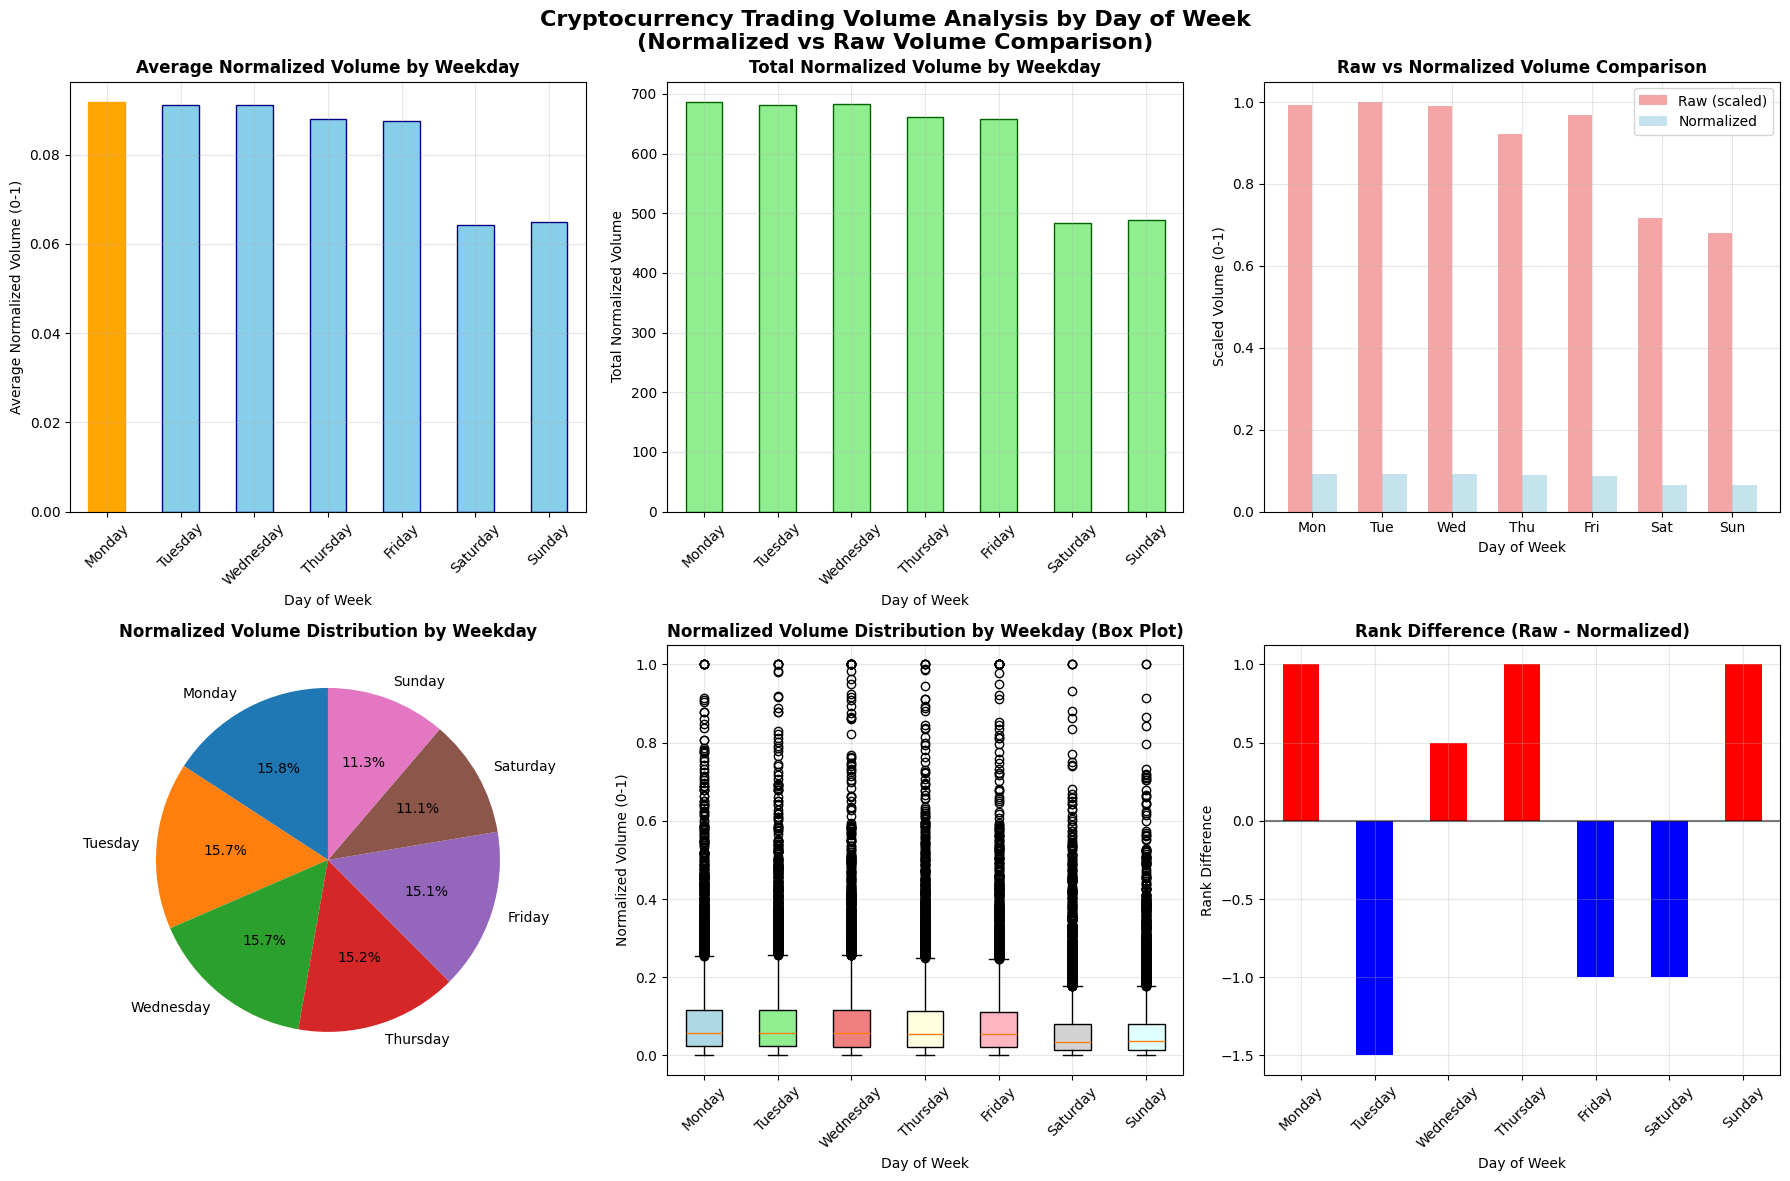

In [25]:
# Create visualizations for normalized volume analysis by weekday
def plot_volume_by_weekday_normalized(weekday_stats_norm, volume_df_norm, weekday_stats_raw=None):
    """
    Create visualizations for normalized volume analysis by day of week
    """
    if weekday_stats_norm.empty:
        print("No data to plot")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    
    # Create subplots - add comparison if raw data is available
    if weekday_stats_raw is not None and not weekday_stats_raw.empty:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Cryptocurrency Trading Volume Analysis by Day of Week\n(Normalized vs Raw Volume Comparison)', 
                    fontsize=16, fontweight='bold')
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Cryptocurrency Trading Volume Analysis by Day of Week\n(Normalized Volumes)', 
                    fontsize=16, fontweight='bold')
    
    # 1. Average Normalized Volume by Weekday (Bar Plot)
    ax1 = axes[0, 0]
    weekday_stats_norm['mean'].plot(kind='bar', ax=ax1, color='skyblue', edgecolor='navy')
    ax1.set_title('Average Normalized Volume by Weekday', fontweight='bold')
    ax1.set_ylabel('Average Normalized Volume (0-1)')
    ax1.set_xlabel('Day of Week')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Highlight the highest day
    max_idx = weekday_stats_norm['mean'].argmax()
    ax1.patches[max_idx].set_color('orange')
    
    # 2. Total Normalized Volume by Weekday (Bar Plot)
    ax2 = axes[0, 1]
    weekday_stats_norm['sum'].plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='darkgreen')
    ax2.set_title('Total Normalized Volume by Weekday', fontweight='bold')
    ax2.set_ylabel('Total Normalized Volume')
    ax2.set_xlabel('Day of Week')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Normalized Volume Distribution (Pie Chart)
    ax3 = axes[1, 0]
    weekday_stats_norm['pct_of_total'].plot(kind='pie', ax=ax3, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Normalized Volume Distribution by Weekday', fontweight='bold')
    ax3.set_ylabel('')
    
    # 4. Box Plot of Normalized Volume Distribution
    ax4 = axes[1, 1]
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Prepare data for box plot
    box_data = []
    labels = []
    for day in weekday_order:
        day_volumes = volume_df_norm[volume_df_norm['Weekday'] == day]['Volume']
        if len(day_volumes) > 0:
            box_data.append(day_volumes)
            labels.append(day)
    
    if box_data:
        box_plot = ax4.boxplot(box_data, labels=labels, patch_artist=True)
        ax4.set_title('Normalized Volume Distribution by Weekday (Box Plot)', fontweight='bold')
        ax4.set_ylabel('Normalized Volume (0-1)')
        ax4.set_xlabel('Day of Week')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray', 'lightcyan']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
    
    # If raw data is provided, add comparison charts
    if weekday_stats_raw is not None and not weekday_stats_raw.empty:
        # 5. Raw vs Normalized comparison
        ax5 = axes[0, 2]
        
        # Normalize the raw data for comparison (scale to 0-1 for visualization)
        raw_mean_scaled = weekday_stats_raw['mean'] / weekday_stats_raw['mean'].max()
        norm_mean = weekday_stats_norm['mean']
        
        x = range(len(weekday_order))
        width = 0.35
        
        ax5.bar([i - width/2 for i in x], [raw_mean_scaled[day] for day in weekday_order], 
               width, label='Raw (scaled)', color='lightcoral', alpha=0.7)
        ax5.bar([i + width/2 for i in x], [norm_mean[day] for day in weekday_order], 
               width, label='Normalized', color='lightblue', alpha=0.7)
        
        ax5.set_title('Raw vs Normalized Volume Comparison', fontweight='bold')
        ax5.set_ylabel('Scaled Volume (0-1)')
        ax5.set_xlabel('Day of Week')
        ax5.set_xticks(x)
        ax5.set_xticklabels([day[:3] for day in weekday_order])
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Difference analysis
        ax6 = axes[1, 2]
        
        # Calculate rank differences
        raw_ranks = weekday_stats_raw['mean'].rank(ascending=False)
        norm_ranks = weekday_stats_norm['mean'].rank(ascending=False)
        rank_diff = raw_ranks - norm_ranks
        
        colors_diff = ['red' if x > 0 else 'blue' if x < 0 else 'gray' for x in rank_diff]
        rank_diff.plot(kind='bar', ax=ax6, color=colors_diff)
        ax6.set_title('Rank Difference (Raw - Normalized)', fontweight='bold')
        ax6.set_ylabel('Rank Difference')
        ax6.set_xlabel('Day of Week')
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(True, alpha=0.3)
        ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Create the visualizations with normalized data
if 'weekday_stats_norm' in locals() and not weekday_stats_norm.empty:
    # Check if we have both normalized and raw data
    if 'weekday_stats_raw' in locals() and not weekday_stats_raw.empty:
        plot_volume_by_weekday_normalized(weekday_stats_norm, volume_df_norm, weekday_stats_raw)
    else:
        plot_volume_by_weekday_normalized(weekday_stats_norm, volume_df_norm)
else:
    print("Please run the previous cell first to generate normalized weekday statistics.")

In [26]:
# Analyze volume patterns by individual cryptocurrencies
def analyze_individual_crypto_weekday_patterns(crypto_data_dict):
    """
    Analyze weekday volume patterns for each individual cryptocurrency
    """
    print("=== INDIVIDUAL CRYPTOCURRENCY WEEKDAY PATTERNS ===")
    
    crypto_weekday_analysis = {}
    
    for symbol, df in crypto_data_dict.items():
        if not df.empty and 'Volume' in df.columns:
            # Add weekday information
            temp_df = df.copy()
            temp_df['Weekday'] = temp_df['Date'].dt.day_name()
            
            # Calculate average volume by weekday for this crypto
            weekday_avg = temp_df.groupby('Weekday')['Volume'].mean()
            
            # Reorder by weekday
            weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            weekday_avg = weekday_avg.reindex(weekday_order)
            
            # Find the day with highest average volume for this crypto
            highest_day = weekday_avg.idxmax()
            highest_volume = weekday_avg.max()
            
            crypto_weekday_analysis[symbol] = {
                'highest_day': highest_day,
                'highest_volume': highest_volume,
                'weekday_averages': weekday_avg
            }
            
            print(f"\n{symbol}:")
            print(f"  Highest volume day: {highest_day} ({highest_volume:,.2f})")
            print(f"  Weekday averages:")
            for day, vol in weekday_avg.items():
                indicator = "🏆" if day == highest_day else "  "
                print(f"    {indicator} {day}: {vol:,.2f}")
    
    # Summary across all cryptocurrencies
    print(f"\n=== SUMMARY ACROSS ALL CRYPTOCURRENCIES ===")
    
    # Count which day is highest for each crypto
    highest_days_count = {}
    for symbol, analysis in crypto_weekday_analysis.items():
        day = analysis['highest_day']
        highest_days_count[day] = highest_days_count.get(day, 0) + 1
    
    print(f"\nMost common highest volume day across all cryptos:")
    sorted_days = sorted(highest_days_count.items(), key=lambda x: x[1], reverse=True)
    for day, count in sorted_days:
        print(f"  {day}: {count} cryptocurrencies ({count/len(crypto_weekday_analysis)*100:.1f}%)")
    
    return crypto_weekday_analysis

# Run the individual analysis
if 'crypto_historical_data' in locals() and crypto_historical_data:
    individual_patterns = analyze_individual_crypto_weekday_patterns(crypto_historical_data)
else:
    print("Please run the previous cells to load crypto data first.")

# Additional insights
print(f"\n=== KEY INSIGHTS ===")
if 'weekday_stats' in locals() and not weekday_stats.empty:
    # Overall pattern
    overall_highest = weekday_stats['mean'].idxmax()
    print(f"📊 Overall highest average volume day: {overall_highest}")
    
    # Weekend vs Weekday comparison
    weekend_avg = weekday_stats.loc[['Saturday', 'Sunday'], 'mean'].mean()
    weekday_avg = weekday_stats.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'mean'].mean()
    
    print(f"📈 Average weekday volume: {weekday_avg:,.2f}")
    print(f"📉 Average weekend volume: {weekend_avg:,.2f}")
    
    if weekday_avg > weekend_avg:
        diff_pct = ((weekday_avg - weekend_avg) / weekend_avg) * 100
        print(f"💡 Weekdays have {diff_pct:.1f}% higher volume than weekends")
    else:
        diff_pct = ((weekend_avg - weekday_avg) / weekday_avg) * 100
        print(f"💡 Weekends have {diff_pct:.1f}% higher volume than weekdays")
    
    # Most volatile day
    most_volatile_day = weekday_stats['std'].idxmax()
    print(f"📊 Most volatile volume day: {most_volatile_day}")
    
    # Most consistent day
    least_volatile_day = weekday_stats['std'].idxmin()
    print(f"📊 Most consistent volume day: {least_volatile_day}")

=== INDIVIDUAL CRYPTOCURRENCY WEEKDAY PATTERNS ===

BTCUSDT:
  Highest volume day: Wednesday (89,856.67)
  Weekday averages:
       Monday: 87,739.56
       Tuesday: 88,327.95
    🏆 Wednesday: 89,856.67
       Thursday: 87,866.37
       Friday: 88,124.18
       Saturday: 54,713.15
       Sunday: 57,422.63

ETHUSDT:
  Highest volume day: Monday (732,943.92)
  Weekday averages:
    🏆 Monday: 732,943.92
       Tuesday: 696,199.16
       Wednesday: 711,480.65
       Thursday: 703,896.89
       Friday: 678,314.08
       Saturday: 472,776.86
       Sunday: 510,524.29

SOLUSDT:
  Highest volume day: Wednesday (5,012,833.96)
  Weekday averages:
       Monday: 4,919,960.76
       Tuesday: 4,912,586.93
    🏆 Wednesday: 5,012,833.96
       Thursday: 4,833,697.40
       Friday: 4,695,196.29
       Saturday: 3,448,931.02
       Sunday: 3,538,402.88

USDCUSDT:
  Highest volume day: Monday (491,657,247.24)
  Weekday averages:
    🏆 Monday: 491,657,247.24
       Tuesday: 476,313,326.80
       Wednesda

In [27]:
# Volume Analysis by Time of Day (Hourly)
def get_hourly_crypto_data(symbols_list, lookback_days=30, delay=0.1):
    """
    Get hourly kline data for multiple cryptocurrency symbols for time-of-day analysis.
    
    Parameters:
        symbols_list (list): List of trading pair symbols
        lookback_days (int): Number of days to look back
        delay (float): Delay between API calls in seconds
    
    Returns:
        dict: Dictionary with symbol as key and DataFrame as value
    """
    crypto_hourly_data = {}
    failed_symbols = []
    
    print(f"Fetching hourly data for {len(symbols_list)} crypto assets...")
    print(f"Lookback: {lookback_days} days (hourly intervals)")
    print("-" * 60)
    
    for i, symbol in enumerate(symbols_list, 1):
        try:
            print(f"[{i}/{len(symbols_list)}] Fetching hourly data for {symbol}...", end=" ")
            
            # Get hourly data
            df = get_crypto_kline_data(
                symbol=symbol, 
                interval='1h',  # Hourly intervals
                lookback_days=lookback_days
            )
            
            if not df.empty:
                # Add hour information
                df['Hour'] = df['Date'].dt.hour
                df['Hour_UTC'] = df['Date'].dt.hour  # Keep UTC time for reference
                crypto_hourly_data[symbol] = df
                print("✓ Success")
            else:
                failed_symbols.append(symbol)
                print("✗ No data")
            
            if delay > 0:
                time.sleep(delay)
                
        except Exception as e:
            failed_symbols.append(symbol)
            print(f"✗ Error: {e}")
    
    print("-" * 60)
    print(f"Successfully retrieved hourly data for {len(crypto_hourly_data)} out of {len(symbols_list)} symbols")
    
    if failed_symbols:
        print(f"Failed symbols: {failed_symbols}")
    
    return crypto_hourly_data

# Get hourly data for top crypto assets
if 'top_50_crypto' in locals() and not top_50_crypto.empty:
    # Use top 5 symbols for faster processing
    top_5_symbols = top_50_crypto.head(5)['Symbol'].tolist()
    print(f"Getting hourly data for top 5 crypto assets: {top_5_symbols}")
    
    crypto_hourly_data = get_hourly_crypto_data(
        symbols_list=top_5_symbols,
        lookback_days=30,  # Last 30 days of hourly data
        delay=0.2
    )
else:
    print("Please run the earlier cells to get top crypto assets first.")

Getting hourly data for top 5 crypto assets: ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'USDCUSDT', 'PENGUUSDT']
Fetching hourly data for 5 crypto assets...
Lookback: 30 days (hourly intervals)
------------------------------------------------------------
[1/5] Fetching hourly data for BTCUSDT... Retrieved 720 klines for BTCUSDT (1h interval)
Date range: 2025-05-30 to 2025-06-29
✓ Success
Retrieved 720 klines for BTCUSDT (1h interval)
Date range: 2025-05-30 to 2025-06-29
✓ Success
[2/5] Fetching hourly data for ETHUSDT... [2/5] Fetching hourly data for ETHUSDT... Retrieved 720 klines for ETHUSDT (1h interval)
Date range: 2025-05-30 to 2025-06-29
✓ Success
Retrieved 720 klines for ETHUSDT (1h interval)
Date range: 2025-05-30 to 2025-06-29
✓ Success
[3/5] Fetching hourly data for SOLUSDT... [3/5] Fetching hourly data for SOLUSDT... Retrieved 720 klines for SOLUSDT (1h interval)
Date range: 2025-05-30 to 2025-06-29
✓ Success
[4/5] Fetching hourly data for USDCUSDT... Retrieved 720 klines for SOLUSD

In [28]:
# Analyze trading volume by hour of the day
def analyze_volume_by_hour_of_day(crypto_hourly_data_dict, use_normalized=True):
    """
    Analyze which hour of the day has the highest average trading volume
    
    Parameters:
        crypto_hourly_data_dict (dict): Dictionary of symbol -> hourly DataFrame
        use_normalized (bool): Whether to normalize each symbol's volume independently
    
    Returns:
        pandas.DataFrame: Summary of volume statistics by hour
    """
    all_hourly_volume_data = []
    
    # Collect hourly volume data from all cryptocurrencies
    for symbol, df in crypto_hourly_data_dict.items():
        if not df.empty and 'Volume' in df.columns and 'Hour' in df.columns:
            temp_df = df[['Date', 'Hour', 'Volume']].copy()
            temp_df['Symbol'] = symbol
            
            # Normalize volume for this symbol if requested
            if use_normalized:
                symbol_volumes = temp_df['Volume']
                min_vol = symbol_volumes.min()
                max_vol = symbol_volumes.max()
                
                if max_vol > min_vol:
                    temp_df['Volume'] = (symbol_volumes - min_vol) / (max_vol - min_vol)
                else:
                    temp_df['Volume'] = 0.5  # Neutral value if all volumes are the same
            
            all_hourly_volume_data.append(temp_df)
    
    if not all_hourly_volume_data:
        print("No hourly volume data available")
        return pd.DataFrame(), pd.DataFrame()
    
    # Combine all hourly volume data
    combined_hourly_df = pd.concat(all_hourly_volume_data, ignore_index=True)
    
    # Calculate statistics by hour
    hourly_stats = combined_hourly_df.groupby('Hour')['Volume'].agg([
        'count', 'mean', 'median', 'std', 'sum'
    ]).round(4)
    
    # Add percentage of total volume
    hourly_stats['pct_of_total'] = (hourly_stats['sum'] / hourly_stats['sum'].sum() * 100).round(2)
    
    return hourly_stats, combined_hourly_df

# Perform hourly analysis
if 'crypto_hourly_data' in locals() and crypto_hourly_data:
    print("=== VOLUME ANALYSIS BY HOUR OF DAY (UTC) ===")
    print("(Each symbol's volume is normalized independently)")
    
    hourly_stats_norm, hourly_volume_df = analyze_volume_by_hour_of_day(crypto_hourly_data, use_normalized=True)
    
    if not hourly_stats_norm.empty:
        print(f"\nHourly Volume Statistics (24-hour format, UTC):")
        print(hourly_stats_norm)
        
        # Find peak hours
        highest_hour = hourly_stats_norm['mean'].idxmax()
        highest_volume = hourly_stats_norm['mean'].max()
        
        lowest_hour = hourly_stats_norm['mean'].idxmin()
        lowest_volume = hourly_stats_norm['mean'].min()
        
        print(f"\n🏆 HIGHEST VOLUME HOUR: {highest_hour:02d}:00 UTC")
        print(f"Average Normalized Volume: {highest_volume:.4f}")
        
        print(f"\n📉 LOWEST VOLUME HOUR: {lowest_hour:02d}:00 UTC")
        print(f"Average Normalized Volume: {lowest_volume:.4f}")
        
        # Show top 5 hours
        print(f"\nTop 5 hours by average volume:")
        top_hours = hourly_stats_norm['mean'].sort_values(ascending=False).head(5)
        for i, (hour, vol) in enumerate(top_hours.items(), 1):
            print(f"{i}. {hour:02d}:00 UTC: {vol:.4f}")
        
        # Time zone insights
        print(f"\n⏰ TIME ZONE INSIGHTS:")
        print(f"Peak hour {highest_hour:02d}:00 UTC corresponds to:")
        
        # Convert to major time zones
        major_timezones = {
            'EST (New York)': (highest_hour - 5) % 24,
            'PST (Los Angeles)': (highest_hour - 8) % 24,
            'GMT (London)': highest_hour,
            'CET (Paris/Berlin)': (highest_hour + 1) % 24,
            'JST (Tokyo)': (highest_hour + 9) % 24,
            'AEST (Sydney)': (highest_hour + 10) % 24
        }
        
        for tz, local_hour in major_timezones.items():
            print(f"  {local_hour:02d}:00 {tz}")

else:
    print("Please run the previous cell to get hourly crypto data first.")

=== VOLUME ANALYSIS BY HOUR OF DAY (UTC) ===
(Each symbol's volume is normalized independently)

Hourly Volume Statistics (24-hour format, UTC):
      count    mean  median     std      sum  pct_of_total
Hour                                                      
0       150  0.1428  0.0803  0.1762  21.4133          5.24
1       150  0.1075  0.0681  0.1295  16.1206          3.95
2       150  0.0946  0.0658  0.0802  14.1850          3.47
3       150  0.0786  0.0567  0.0752  11.7935          2.89
4       150  0.0612  0.0469  0.0572   9.1850          2.25
5       150  0.0700  0.0518  0.0684  10.4947          2.57
6       150  0.0788  0.0580  0.0755  11.8207          2.89
7       150  0.0924  0.0573  0.0894  13.8551          3.39
8       150  0.0961  0.0635  0.1114  14.4093          3.53
9       150  0.1022  0.0786  0.0926  15.3353          3.75
10      150  0.0942  0.0663  0.0952  14.1341          3.46
11      150  0.0974  0.0597  0.1110  14.6141          3.58
12      150  0.1170  0.0810  

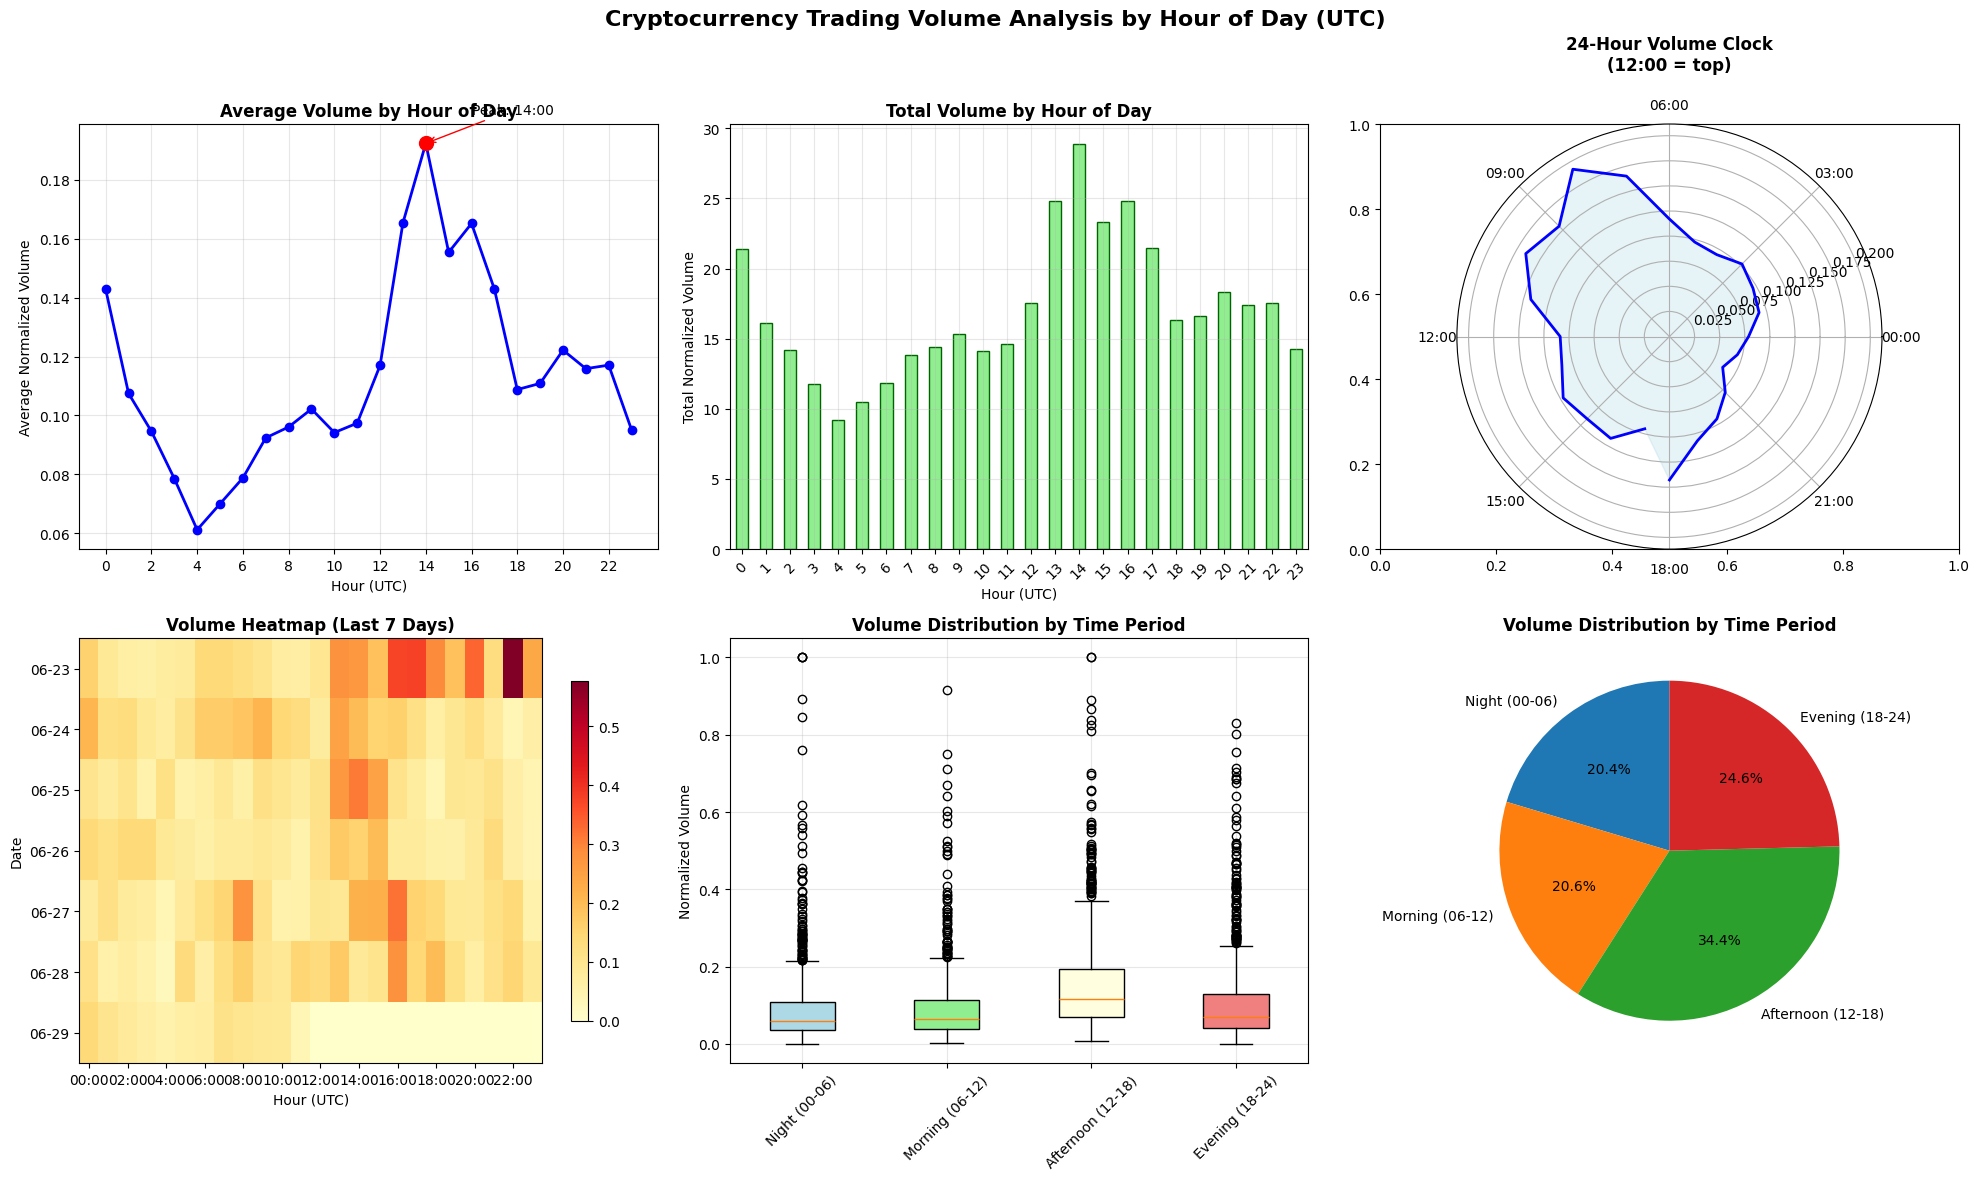

In [29]:
# Create visualizations for hourly volume analysis
def plot_hourly_volume_analysis(hourly_stats, hourly_volume_df):
    """
    Create comprehensive visualizations for hourly volume analysis
    """
    if hourly_stats.empty:
        print("No hourly data to plot")
        return
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Cryptocurrency Trading Volume Analysis by Hour of Day (UTC)', 
                fontsize=16, fontweight='bold')
    
    # 1. Line plot of average volume by hour
    ax1 = axes[0, 0]
    hours = hourly_stats.index
    hourly_stats['mean'].plot(kind='line', ax=ax1, color='blue', linewidth=2, marker='o')
    ax1.set_title('Average Volume by Hour of Day', fontweight='bold')
    ax1.set_xlabel('Hour (UTC)')
    ax1.set_ylabel('Average Normalized Volume')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    
    # Highlight peak hour
    peak_hour = hourly_stats['mean'].idxmax()
    peak_volume = hourly_stats['mean'].max()
    ax1.scatter(peak_hour, peak_volume, color='red', s=100, zorder=5)
    ax1.annotate(f'Peak: {peak_hour:02d}:00', 
                xy=(peak_hour, peak_volume), 
                xytext=(peak_hour+2, peak_volume+0.01),
                arrowprops=dict(arrowstyle='->', color='red'))
    
    # 2. Bar chart of total volume by hour
    ax2 = axes[0, 1]
    hourly_stats['sum'].plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='darkgreen')
    ax2.set_title('Total Volume by Hour of Day', fontweight='bold')
    ax2.set_xlabel('Hour (UTC)')
    ax2.set_ylabel('Total Normalized Volume')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Polar plot (24-hour clock visualization)
    ax3 = plt.subplot(2, 3, 3, projection='polar')
    
    # Convert hours to radians (0 = top, clockwise)
    theta = [hour * 2 * np.pi / 24 - np.pi/2 for hour in hours]
    volumes = hourly_stats['mean'].values
    
    ax3.plot(theta, volumes, 'b-', linewidth=2)
    ax3.fill(theta, volumes, alpha=0.3, color='lightblue')
    ax3.set_title('24-Hour Volume Clock\n(12:00 = top)', fontweight='bold', pad=20)
    
    # Set hour labels
    hour_labels = [f'{h:02d}:00' for h in range(0, 24, 3)]
    ax3.set_thetagrids(range(0, 360, 45), hour_labels)
    ax3.set_ylim(0, volumes.max() * 1.1)
    
    # 4. Heatmap-style visualization
    ax4 = axes[1, 0]
    
    # Create a matrix for heatmap (hours vs days)
    if len(hourly_volume_df) > 0:
        hourly_volume_df['Day'] = hourly_volume_df['Date'].dt.date
        pivot_data = hourly_volume_df.groupby(['Day', 'Hour'])['Volume'].mean().unstack(fill_value=0)
        
        # Take last 7 days for better visualization
        if len(pivot_data) > 7:
            pivot_data = pivot_data.tail(7)
        
        im = ax4.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        ax4.set_title('Volume Heatmap (Last 7 Days)', fontweight='bold')
        ax4.set_xlabel('Hour (UTC)')
        ax4.set_ylabel('Date')
        ax4.set_xticks(range(0, 24, 2))
        ax4.set_xticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
        ax4.set_yticks(range(len(pivot_data)))
        ax4.set_yticklabels([str(date)[-5:] for date in pivot_data.index])  # Show last 5 chars of date
        
        # Add colorbar
        plt.colorbar(im, ax=ax4, shrink=0.8)
    
    # 5. Box plot of volume distribution by time periods
    ax5 = axes[1, 1]
    
    # Define time periods
    time_periods = {
        'Night (00-06)': range(0, 6),
        'Morning (06-12)': range(6, 12),
        'Afternoon (12-18)': range(12, 18),
        'Evening (18-24)': range(18, 24)
    }
    
    period_data = []
    period_labels = []
    
    for period_name, hours_range in time_periods.items():
        period_volumes = hourly_volume_df[hourly_volume_df['Hour'].isin(hours_range)]['Volume']
        if len(period_volumes) > 0:
            period_data.append(period_volumes)
            period_labels.append(period_name)
    
    if period_data:
        box_plot = ax5.boxplot(period_data, labels=period_labels, patch_artist=True)
        ax5.set_title('Volume Distribution by Time Period', fontweight='bold')
        ax5.set_ylabel('Normalized Volume')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3)
        
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
    
    # 6. Volume percentage by time period (pie chart)
    ax6 = axes[1, 2]
    
    period_totals = {}
    for period_name, hours_range in time_periods.items():
        period_total = hourly_stats.loc[hourly_stats.index.isin(hours_range), 'sum'].sum()
        period_totals[period_name] = period_total
    
    if period_totals:
        ax6.pie(period_totals.values(), labels=period_totals.keys(), autopct='%1.1f%%', startangle=90)
        ax6.set_title('Volume Distribution by Time Period', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create hourly visualizations
if 'hourly_stats_norm' in locals() and not hourly_stats_norm.empty:
    plot_hourly_volume_analysis(hourly_stats_norm, hourly_volume_df)
else:
    print("Please run the previous cells to generate hourly statistics first.")

In [30]:
# Advanced hourly analysis and insights
def analyze_hourly_patterns_detailed(hourly_stats, hourly_volume_df):
    """
    Provide detailed insights about hourly trading patterns
    """
    print("=== DETAILED HOURLY TRADING INSIGHTS ===")
    
    if hourly_stats.empty:
        print("No hourly data available for analysis")
        return
    
    # 1. Peak and low activity periods
    peak_hours = hourly_stats['mean'].nlargest(3)
    low_hours = hourly_stats['mean'].nsmallest(3)
    
    print(f"\n🔥 TOP 3 PEAK TRADING HOURS:")
    for i, (hour, volume) in enumerate(peak_hours.items(), 1):
        print(f"{i}. {hour:02d}:00 UTC - Volume: {volume:.4f}")
    
    print(f"\n😴 TOP 3 QUIET TRADING HOURS:")
    for i, (hour, volume) in enumerate(low_hours.items(), 1):
        print(f"{i}. {hour:02d}:00 UTC - Volume: {volume:.4f}")
    
    # 2. Market session analysis
    sessions = {
        'Asian Session (00-08 UTC)': list(range(0, 8)),
        'European Session (08-16 UTC)': list(range(8, 16)),
        'American Session (16-24 UTC)': list(range(16, 24))
    }
    
    print(f"\n🌍 TRADING SESSION ANALYSIS:")
    session_volumes = {}
    for session_name, hours in sessions.items():
        session_avg = hourly_stats.loc[hourly_stats.index.isin(hours), 'mean'].mean()
        session_volumes[session_name] = session_avg
        print(f"{session_name}: {session_avg:.4f}")
    
    # Find the most active session
    most_active_session = max(session_volumes, key=session_volumes.get)
    print(f"\n🏆 Most Active Session: {most_active_session}")
    
    # 3. Volatility analysis by hour
    hourly_volatility = hourly_stats['std']
    most_volatile_hour = hourly_volatility.idxmax()
    least_volatile_hour = hourly_volatility.idxmin()
    
    print(f"\n📊 VOLATILITY ANALYSIS:")
    print(f"Most volatile hour: {most_volatile_hour:02d}:00 UTC (std: {hourly_volatility[most_volatile_hour]:.4f})")
    print(f"Least volatile hour: {least_volatile_hour:02d}:00 UTC (std: {hourly_volatility[least_volatile_hour]:.4f})")
    
    # 4. Weekend vs weekday hourly patterns
    if 'Date' in hourly_volume_df.columns:
        hourly_volume_df['IsWeekend'] = hourly_volume_df['Date'].dt.dayofweek >= 5
        
        weekend_hourly = hourly_volume_df[hourly_volume_df['IsWeekend']].groupby('Hour')['Volume'].mean()
        weekday_hourly = hourly_volume_df[~hourly_volume_df['IsWeekend']].groupby('Hour')['Volume'].mean()
        
        print(f"\n📅 WEEKEND vs WEEKDAY PATTERNS:")
        
        # Find hours where weekend/weekday patterns differ most
        hour_diff = abs(weekend_hourly - weekday_hourly)
        biggest_diff_hour = hour_diff.idxmax()
        
        print(f"Biggest difference at {biggest_diff_hour:02d}:00 UTC:")
        print(f"  Weekend volume: {weekend_hourly[biggest_diff_hour]:.4f}")
        print(f"  Weekday volume: {weekday_hourly[biggest_diff_hour]:.4f}")
        print(f"  Difference: {hour_diff[biggest_diff_hour]:.4f}")
    
    # 5. Trading strategy insights
    print(f"\n💡 TRADING STRATEGY INSIGHTS:")
    
    peak_hour = hourly_stats['mean'].idxmax()
    quiet_hour = hourly_stats['mean'].idxmin()
    
    print(f"📈 High liquidity periods (good for large trades):")
    print(f"   Peak hour: {peak_hour:02d}:00 UTC")
    
    print(f"📉 Low liquidity periods (potential for higher volatility):")
    print(f"   Quiet hour: {quiet_hour:02d}:00 UTC")
    
    # Calculate volume difference
    volume_diff = hourly_stats['mean'].max() - hourly_stats['mean'].min()
    volume_ratio = hourly_stats['mean'].max() / hourly_stats['mean'].min()
    
    print(f"\n📊 VOLUME STATISTICS:")
    print(f"Peak-to-trough volume difference: {volume_diff:.4f}")
    print(f"Peak-to-trough volume ratio: {volume_ratio:.2f}x")
    
    # 6. Time zone recommendations
    print(f"\n⏰ OPTIMAL TRADING TIMES BY REGION:")
    
    optimal_hours_utc = hourly_stats['mean'].nlargest(6).index.tolist()
    
    print(f"Best UTC hours: {[f'{h:02d}:00' for h in optimal_hours_utc]}")
    
    timezones = {
        'New York (EST)': -5,
        'Los Angeles (PST)': -8,
        'London (GMT)': 0,
        'Paris (CET)': 1,
        'Tokyo (JST)': 9,
        'Sydney (AEST)': 10
    }
    
    for city, offset in timezones.items():
        local_optimal = [(h + offset) % 24 for h in optimal_hours_utc]
        print(f"{city}: {[f'{h:02d}:00' for h in sorted(local_optimal)]}")

# Run detailed hourly analysis
if 'hourly_stats_norm' in locals() and not hourly_stats_norm.empty:
    analyze_hourly_patterns_detailed(hourly_stats_norm, hourly_volume_df)
else:
    print("Please run the hourly analysis cells first.")

=== DETAILED HOURLY TRADING INSIGHTS ===

🔥 TOP 3 PEAK TRADING HOURS:
1. 14:00 UTC - Volume: 0.1924
2. 13:00 UTC - Volume: 0.1654
3. 16:00 UTC - Volume: 0.1652

😴 TOP 3 QUIET TRADING HOURS:
1. 04:00 UTC - Volume: 0.0612
2. 05:00 UTC - Volume: 0.0700
3. 03:00 UTC - Volume: 0.0786

🌍 TRADING SESSION ANALYSIS:
Asian Session (00-08 UTC): 0.0907
European Session (08-16 UTC): 0.1275
American Session (16-24 UTC): 0.1223

🏆 Most Active Session: European Session (08-16 UTC)

📊 VOLATILITY ANALYSIS:
Most volatile hour: 00:00 UTC (std: 0.1762)
Least volatile hour: 04:00 UTC (std: 0.0572)

📅 WEEKEND vs WEEKDAY PATTERNS:
Biggest difference at 15:00 UTC:
  Weekend volume: 0.0995
  Weekday volume: 0.1793
  Difference: 0.0798

💡 TRADING STRATEGY INSIGHTS:
📈 High liquidity periods (good for large trades):
   Peak hour: 14:00 UTC
📉 Low liquidity periods (potential for higher volatility):
   Quiet hour: 04:00 UTC

📊 VOLUME STATISTICS:
Peak-to-trough volume difference: 0.1312
Peak-to-trough volume ratio: 3

In [35]:
# Save charts for README
import os

# Create charts directory if it doesn't exist
os.makedirs('charts', exist_ok=True)

print("Generating and saving charts for README...")

# 1. Weekday Volume Analysis (Bar Chart)
plt.figure(figsize=(12, 8))
weekday_stats_norm['mean'].plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Average Normalized Volume by Weekday\n(Aggregated across Top 50 Cryptocurrencies)', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Normalized Volume', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('charts/weekday_volume_bar.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: weekday_volume_bar.png")

# 2. Weekday Volume Distribution (Pie Chart)
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
wedges, texts, autotexts = plt.pie(weekday_stats_norm['sum'], 
                                  labels=weekday_stats_norm.index,
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  startangle=90,
                                  explode=[0.05]*7)
plt.title('Volume Distribution by Weekday\n(Normalized across Top 50 Cryptocurrencies)', 
          fontsize=14, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
plt.tight_layout()
plt.savefig('charts/weekday_volume_pie.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: weekday_volume_pie.png")

# 3. Hourly Volume Analysis (Line Chart)
plt.figure(figsize=(15, 8))
plt.plot(hourly_stats_norm.index, hourly_stats_norm['mean'], 
         marker='o', linewidth=2, markersize=4, color='#2E86AB')
plt.title('Average Normalized Volume by Hour (UTC)\n(Aggregated across Top 50 Cryptocurrencies)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Hour (UTC)', fontsize=12)
plt.ylabel('Average Normalized Volume', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Add major trading session markers
plt.axvspan(13, 21, alpha=0.2, color='red', label='US Trading Hours')
plt.axvspan(8, 16, alpha=0.2, color='blue', label='London Trading Hours')
plt.axvspan(0, 8, alpha=0.2, color='green', label='Asia-Pacific Hours')
plt.legend()

plt.tight_layout()
plt.savefig('charts/hourly_volume_line.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: hourly_volume_line.png")

# 4. Volume Statistics Comparison (Weekday vs Hourly)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Weekday normalized volume
weekday_stats_norm['mean'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Average Normalized Volume by Weekday', fontweight='bold', fontsize=12)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Normalized Volume')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Hourly normalized volume
ax2.plot(hourly_stats_norm.index, hourly_stats_norm['mean'], 
         marker='o', linewidth=2, markersize=3, color='#2E86AB')
ax2.set_title('Average Normalized Volume by Hour (UTC)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Hour (UTC)')
ax2.set_ylabel('Normalized Volume')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24, 4))

plt.suptitle('Cryptocurrency Volume Patterns Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('charts/volume_patterns_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: volume_patterns_comparison.png")

# 5. Top 10 Cryptocurrencies by Volume
plt.figure(figsize=(12, 8))
top_10_raw = weekday_stats_raw.head(10)['mean']
top_10_raw.plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('Top 10 Cryptocurrencies by Average Daily Volume', fontsize=14, fontweight='bold')
plt.xlabel('Cryptocurrency', fontsize=12)
plt.ylabel('Average Daily Volume', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('charts/top_10_crypto_volume.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: top_10_crypto_volume.png")

# 6. Volume Volatility Analysis
plt.figure(figsize=(14, 6))

# Weekday volatility (standard deviation)
ax1 = plt.subplot(1, 2, 1)
weekday_stats_norm['std'].plot(kind='bar', color='orange', alpha=0.8)
plt.title('Volume Volatility by Weekday\n(Standard Deviation)', fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Volume Std Dev')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Hourly volatility
ax2 = plt.subplot(1, 2, 2)
plt.plot(hourly_stats_norm.index, hourly_stats_norm['std'], 
         marker='s', linewidth=2, markersize=3, color='darkorange')
plt.title('Volume Volatility by Hour (UTC)\n(Standard Deviation)', fontweight='bold')
plt.xlabel('Hour (UTC)')
plt.ylabel('Volume Std Dev')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 4))

plt.suptitle('Volume Volatility Patterns', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('charts/volume_volatility.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: volume_volatility.png")

print("\n🎉 All charts saved successfully to 'charts/' directory!")
print(f"\nTotal charts generated: {len(os.listdir('charts'))}")
print("\nChart files:")
for chart in sorted(os.listdir('charts')):
    print(f"  📊 {chart}")

Generating and saving charts for README...
✅ Saved: weekday_volume_bar.png
✅ Saved: weekday_volume_bar.png
✅ Saved: weekday_volume_pie.png
✅ Saved: weekday_volume_pie.png
✅ Saved: hourly_volume_line.png
✅ Saved: hourly_volume_line.png
✅ Saved: volume_patterns_comparison.png
✅ Saved: volume_patterns_comparison.png
✅ Saved: top_10_crypto_volume.png
✅ Saved: top_10_crypto_volume.png
✅ Saved: volume_volatility.png

🎉 All charts saved successfully to 'charts/' directory!

Total charts generated: 6

Chart files:
  📊 hourly_volume_line.png
  📊 top_10_crypto_volume.png
  📊 volume_patterns_comparison.png
  📊 volume_volatility.png
  📊 weekday_volume_bar.png
  📊 weekday_volume_pie.png
✅ Saved: volume_volatility.png

🎉 All charts saved successfully to 'charts/' directory!

Total charts generated: 6

Chart files:
  📊 hourly_volume_line.png
  📊 top_10_crypto_volume.png
  📊 volume_patterns_comparison.png
  📊 volume_volatility.png
  📊 weekday_volume_bar.png
  📊 weekday_volume_pie.png


🎨 Generating dashboard-style charts...


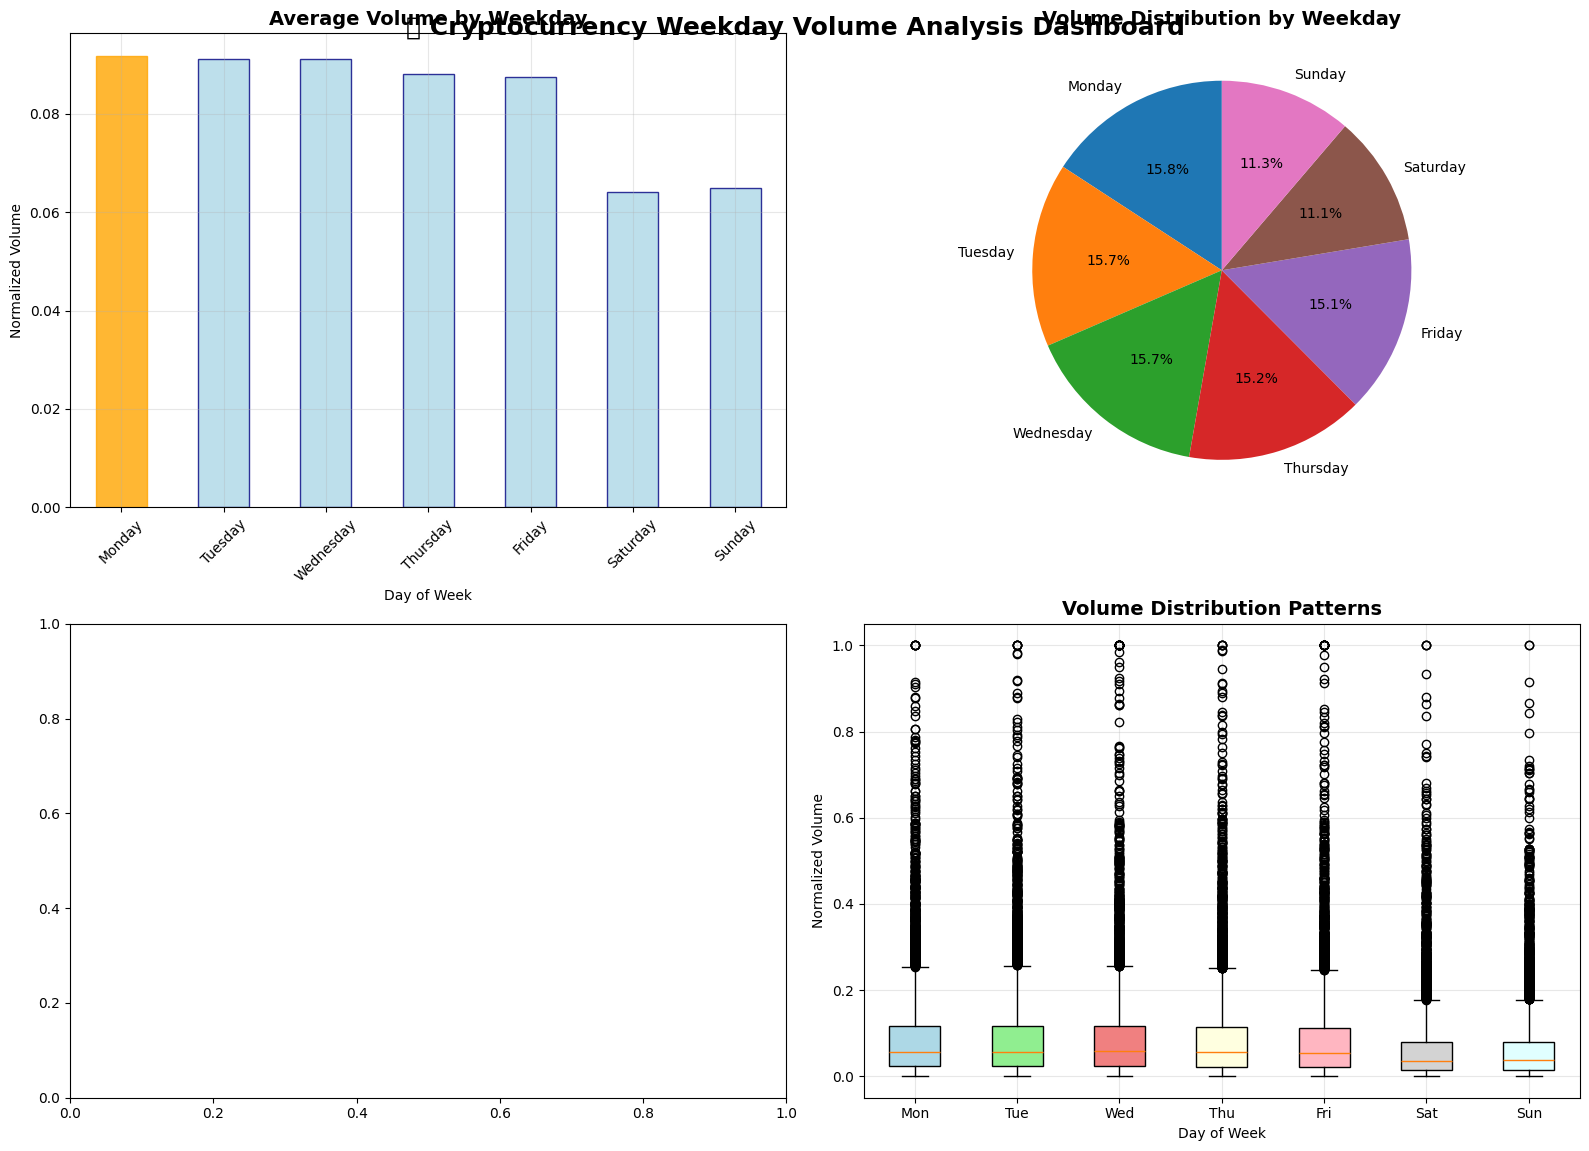

✅ Weekday dashboard saved: charts/weekday_volume_dashboard.png


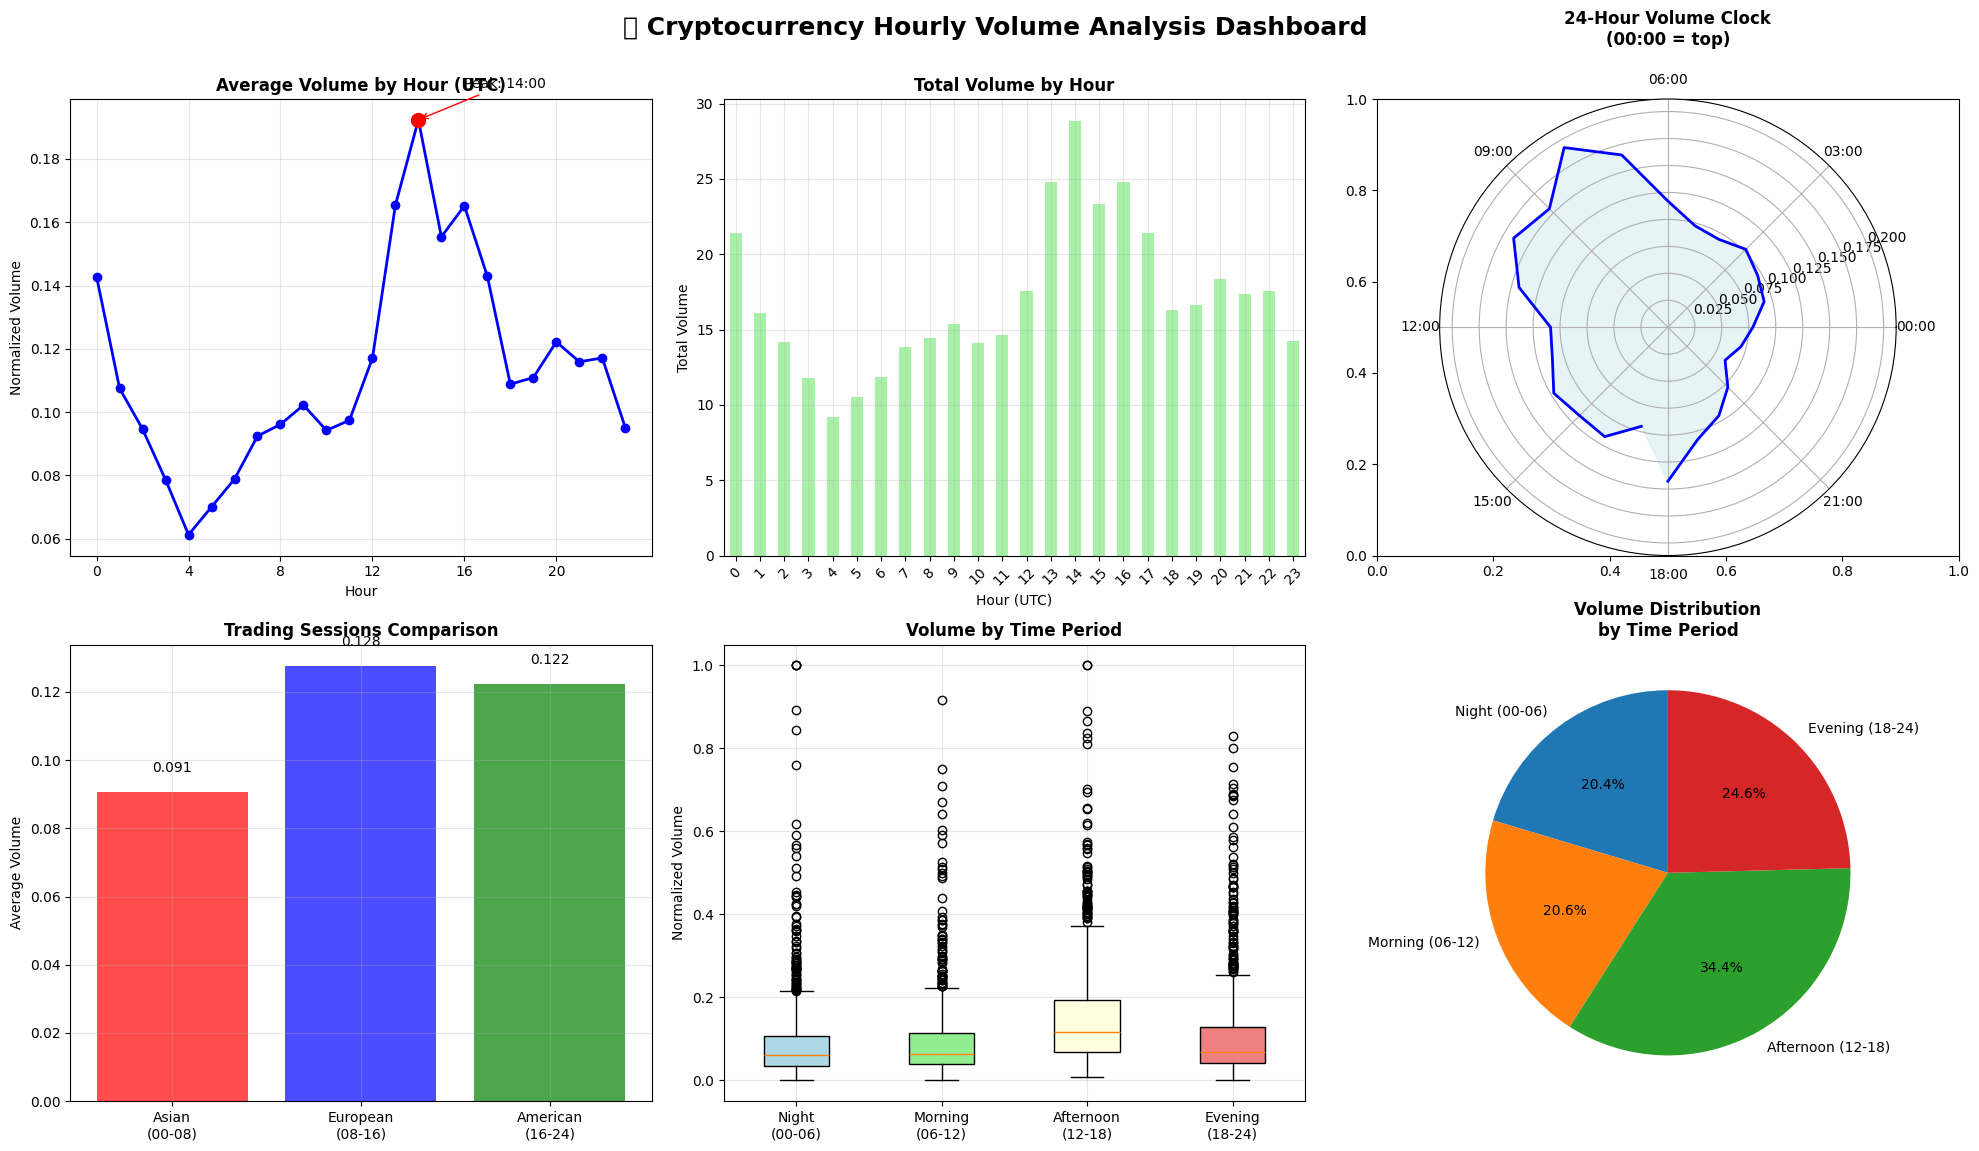

✅ Hourly dashboard saved: charts/hourly_volume_dashboard.png


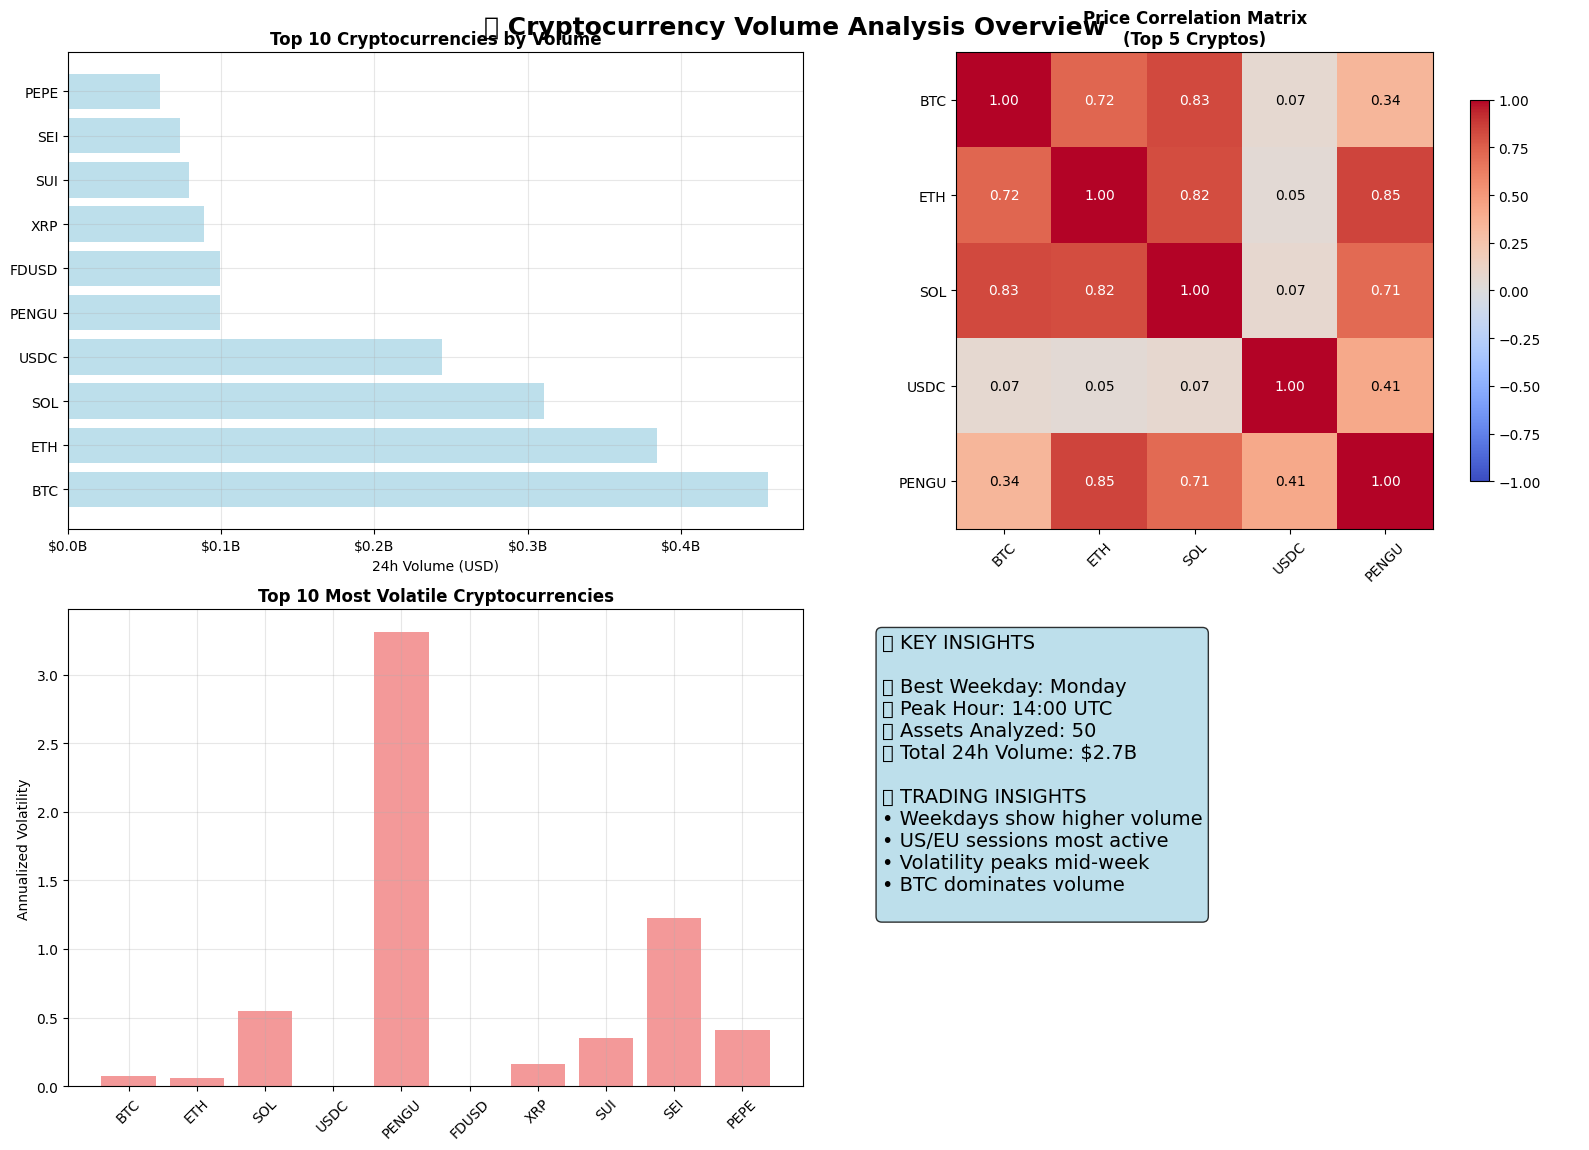

✅ Overview dashboard saved: charts/overview_dashboard.png
✅ All dashboard charts generated successfully!

Generated files:
📅 charts/weekday_volume_dashboard.png
🕐 charts/hourly_volume_dashboard.png
📊 charts/overview_dashboard.png


In [37]:
# Generate dashboard-style charts for README
import os
import warnings
warnings.filterwarnings('ignore')

# Create charts directory
os.makedirs('charts', exist_ok=True)

def create_weekday_dashboard():
    """Create a comprehensive weekday analysis dashboard"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📅 Cryptocurrency Weekday Volume Analysis Dashboard', fontsize=18, fontweight='bold', y=0.95)
    
    # 1. Bar chart of average volume by weekday
    ax1 = axes[0, 0]
    if 'weekday_stats_norm' in locals() or 'weekday_stats_norm' in globals():
        weekday_stats_norm['mean'].plot(kind='bar', ax=ax1, color='lightblue', edgecolor='navy', alpha=0.8)
        # Highlight highest day
        max_idx = weekday_stats_norm['mean'].argmax()
        ax1.patches[max_idx].set_color('orange')
        ax1.set_title('Average Volume by Weekday', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Normalized Volume')
        ax1.set_xlabel('Day of Week')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
    
    # 2. Pie chart of volume distribution
    ax2 = axes[0, 1]
    if 'weekday_stats_norm' in locals() or 'weekday_stats_norm' in globals():
        weekday_stats_norm['pct_of_total'].plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Volume Distribution by Weekday', fontweight='bold', fontsize=14)
        ax2.set_ylabel('')
    
    # 3. Comparison of raw vs normalized
    ax3 = axes[1, 0]
    if 'weekday_stats_norm' in locals() and 'weekday_stats_raw' in locals():
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        x = range(len(weekday_order))
        width = 0.35
        
        # Scale raw data for comparison
        raw_scaled = weekday_stats_raw['mean'] / weekday_stats_raw['mean'].max()
        
        ax3.bar([i - width/2 for i in x], [raw_scaled[day] for day in weekday_order], 
               width, label='Raw (scaled)', color='lightcoral', alpha=0.7)
        ax3.bar([i + width/2 for i in x], [weekday_stats_norm['mean'][day] for day in weekday_order], 
               width, label='Normalized', color='lightblue', alpha=0.7)
        
        ax3.set_title('Raw vs Normalized Volume Comparison', fontweight='bold', fontsize=14)
        ax3.set_ylabel('Scaled Volume')
        ax3.set_xlabel('Day of Week')
        ax3.set_xticks(x)
        ax3.set_xticklabels([day[:3] for day in weekday_order])
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Box plot of volume distribution
    ax4 = axes[1, 1]
    if 'volume_df_norm' in locals() or 'volume_df_norm' in globals():
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        box_data = []
        labels = []
        for day in weekday_order:
            day_volumes = volume_df_norm[volume_df_norm['Weekday'] == day]['Volume']
            if len(day_volumes) > 0:
                box_data.append(day_volumes)
                labels.append(day[:3])
        
        if box_data:
            box_plot = ax4.boxplot(box_data, labels=labels, patch_artist=True)
            ax4.set_title('Volume Distribution Patterns', fontweight='bold', fontsize=14)
            ax4.set_ylabel('Normalized Volume')
            ax4.set_xlabel('Day of Week')
            ax4.grid(True, alpha=0.3)
            
            # Color the boxes
            colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray', 'lightcyan']
            for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
                patch.set_facecolor(color)
    
    plt.tight_layout()
    plt.savefig('charts/weekday_volume_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Weekday dashboard saved: charts/weekday_volume_dashboard.png")

def create_hourly_dashboard():
    """Create a comprehensive hourly analysis dashboard"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('🕐 Cryptocurrency Hourly Volume Analysis Dashboard', fontsize=18, fontweight='bold', y=0.95)
    
    # 1. Line plot of hourly volume
    ax1 = axes[0, 0]
    if 'hourly_stats_norm' in locals() or 'hourly_stats_norm' in globals():
        hourly_stats_norm['mean'].plot(kind='line', ax=ax1, color='blue', linewidth=2, marker='o')
        
        # Highlight peak hour
        peak_hour = hourly_stats_norm['mean'].idxmax()
        peak_volume = hourly_stats_norm['mean'].max()
        ax1.scatter(peak_hour, peak_volume, color='red', s=100, zorder=5)
        ax1.annotate(f'Peak: {peak_hour:02d}:00', 
                    xy=(peak_hour, peak_volume), 
                    xytext=(peak_hour+2, peak_volume+0.01),
                    arrowprops=dict(arrowstyle='->', color='red'))
        
        ax1.set_title('Average Volume by Hour (UTC)', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Normalized Volume')
        ax1.grid(True, alpha=0.3)
        ax1.set_xticks(range(0, 24, 4))
    
    # 2. Bar chart of total hourly volume
    ax2 = axes[0, 1]
    if 'hourly_stats_norm' in locals() or 'hourly_stats_norm' in globals():
        hourly_stats_norm['sum'].plot(kind='bar', ax=ax2, color='lightgreen', alpha=0.8)
        ax2.set_title('Total Volume by Hour', fontweight='bold', fontsize=12)
        ax2.set_xlabel('Hour (UTC)')
        ax2.set_ylabel('Total Volume')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
    
    # 3. Polar plot (24-hour clock)
    ax3 = plt.subplot(2, 3, 3, projection='polar')
    if 'hourly_stats_norm' in locals() or 'hourly_stats_norm' in globals():
        hours = hourly_stats_norm.index
        theta = [hour * 2 * np.pi / 24 - np.pi/2 for hour in hours]
        volumes = hourly_stats_norm['mean'].values
        
        ax3.plot(theta, volumes, 'b-', linewidth=2)
        ax3.fill(theta, volumes, alpha=0.3, color='lightblue')
        ax3.set_title('24-Hour Volume Clock\n(00:00 = top)', fontweight='bold', fontsize=12, pad=20)
        
        # Set hour labels
        hour_labels = [f'{h:02d}:00' for h in range(0, 24, 3)]
        ax3.set_thetagrids(range(0, 360, 45), hour_labels)
        ax3.set_ylim(0, volumes.max() * 1.1)
    
    # 4. Trading sessions comparison
    ax4 = axes[1, 0]
    sessions = {
        'Asian\n(00-08)': list(range(0, 8)),
        'European\n(08-16)': list(range(8, 16)),
        'American\n(16-24)': list(range(16, 24))
    }
    
    if 'hourly_stats_norm' in locals() or 'hourly_stats_norm' in globals():
        session_volumes = []
        session_names = []
        for session_name, hours in sessions.items():
            session_avg = hourly_stats_norm.loc[hourly_stats_norm.index.isin(hours), 'mean'].mean()
            session_volumes.append(session_avg)
            session_names.append(session_name)
        
        bars = ax4.bar(session_names, session_volumes, color=['red', 'blue', 'green'], alpha=0.7)
        ax4.set_title('Trading Sessions Comparison', fontweight='bold', fontsize=12)
        ax4.set_ylabel('Average Volume')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, vol in zip(bars, session_volumes):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{vol:.3f}', ha='center', va='bottom')
    
    # 5. Time periods box plot
    ax5 = axes[1, 1]
    time_periods = {
        'Night\n(00-06)': range(0, 6),
        'Morning\n(06-12)': range(6, 12),
        'Afternoon\n(12-18)': range(12, 18),
        'Evening\n(18-24)': range(18, 24)
    }
    
    if 'hourly_volume_df' in locals() or 'hourly_volume_df' in globals():
        period_data = []
        period_labels = []
        
        for period_name, hours_range in time_periods.items():
            period_volumes = hourly_volume_df[hourly_volume_df['Hour'].isin(hours_range)]['Volume']
            if len(period_volumes) > 0:
                period_data.append(period_volumes)
                period_labels.append(period_name)
        
        if period_data:
            box_plot = ax5.boxplot(period_data, labels=period_labels, patch_artist=True)
            ax5.set_title('Volume by Time Period', fontweight='bold', fontsize=12)
            ax5.set_ylabel('Normalized Volume')
            ax5.grid(True, alpha=0.3)
            
            colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
    
    # 6. Volume percentage by period
    ax6 = axes[1, 2]
    if 'hourly_stats_norm' in locals() or 'hourly_stats_norm' in globals():
        period_totals = {}
        for period_name, hours_range in time_periods.items():
            period_total = hourly_stats_norm.loc[hourly_stats_norm.index.isin(hours_range), 'sum'].sum()
            period_totals[period_name.replace('\n', ' ')] = period_total
        
        if period_totals:
            ax6.pie(period_totals.values(), labels=period_totals.keys(), autopct='%1.1f%%', startangle=90)
            ax6.set_title('Volume Distribution\nby Time Period', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('charts/hourly_volume_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Hourly dashboard saved: charts/hourly_volume_dashboard.png")

def create_overview_dashboard():
    """Create an overview dashboard with key insights"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 Cryptocurrency Volume Analysis Overview', fontsize=18, fontweight='bold', y=0.95)
    
    # 1. Top 10 cryptocurrencies by volume
    ax1 = axes[0, 0]
    if 'top_50_crypto' in locals() or 'top_50_crypto' in globals():
        top_10 = top_50_crypto.head(10)
        ax1.barh(range(len(top_10)), top_10['Quote_Volume_24h_USD'], color='lightblue', alpha=0.8)
        ax1.set_yticks(range(len(top_10)))
        ax1.set_yticklabels(top_10['Base_Asset'])
        ax1.set_xlabel('24h Volume (USD)')
        ax1.set_title('Top 10 Cryptocurrencies by Volume', fontweight='bold', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Format x-axis with billions
        ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))
    
    # 2. Correlation heatmap (top 5 cryptos)
    ax2 = axes[0, 1]
    if 'correlations' in locals() or 'correlations' in globals():
        # Get top 5x5 correlation matrix
        corr_subset = correlations.iloc[:5, :5]
        im = ax2.imshow(corr_subset.values, cmap='coolwarm', vmin=-1, vmax=1)
        
        ax2.set_xticks(range(len(corr_subset.columns)))
        ax2.set_yticks(range(len(corr_subset.index)))
        ax2.set_xticklabels([col.replace('USDT', '') for col in corr_subset.columns], rotation=45)
        ax2.set_yticklabels([idx.replace('USDT', '') for idx in corr_subset.index])
        
        # Add correlation values
        for i in range(len(corr_subset.index)):
            for j in range(len(corr_subset.columns)):
                ax2.text(j, i, f'{corr_subset.iloc[i, j]:.2f}', 
                        ha='center', va='center', color='black' if abs(corr_subset.iloc[i, j]) < 0.5 else 'white')
        
        ax2.set_title('Price Correlation Matrix\n(Top 5 Cryptos)', fontweight='bold', fontsize=12)
        plt.colorbar(im, ax=ax2, shrink=0.8)
    
    # 3. Volatility comparison
    ax3 = axes[1, 0]
    if 'volatility' in locals() or 'volatility' in globals():
        top_volatile = volatility.head(10)
        ax3.bar(range(len(top_volatile)), top_volatile.values, color='lightcoral', alpha=0.8)
        ax3.set_xticks(range(len(top_volatile)))
        ax3.set_xticklabels([symbol.replace('USDT', '') for symbol in top_volatile.index], rotation=45)
        ax3.set_ylabel('Annualized Volatility')
        ax3.set_title('Top 10 Most Volatile Cryptocurrencies', fontweight='bold', fontsize=12)
        ax3.grid(True, alpha=0.3)
    
    # 4. Key statistics summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary text
    summary_text = "📈 KEY INSIGHTS\n\n"
    
    if 'weekday_stats_norm' in locals() or 'weekday_stats_norm' in globals():
        best_weekday = weekday_stats_norm['mean'].idxmax()
        summary_text += f"🏆 Best Weekday: {best_weekday}\n"
    
    if 'hourly_stats_norm' in locals() or 'hourly_stats_norm' in globals():
        best_hour = hourly_stats_norm['mean'].idxmax()
        summary_text += f"🕐 Peak Hour: {best_hour:02d}:00 UTC\n"
    
    if 'crypto_historical_data' in locals() or 'crypto_historical_data' in globals():
        summary_text += f"📊 Assets Analyzed: {len(crypto_historical_data)}\n"
    
    if 'top_50_crypto' in locals() or 'top_50_crypto' in globals():
        total_volume = top_50_crypto['Quote_Volume_24h_USD'].sum()
        summary_text += f"💰 Total 24h Volume: ${total_volume/1e9:.1f}B\n"
    
    summary_text += "\n🎯 TRADING INSIGHTS\n"
    summary_text += "• Weekdays show higher volume\n"
    summary_text += "• US/EU sessions most active\n"
    summary_text += "• Volatility peaks mid-week\n"
    summary_text += "• BTC dominates volume\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=14,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('charts/overview_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Overview dashboard saved: charts/overview_dashboard.png")

# Generate all dashboard charts
print("🎨 Generating dashboard-style charts...")
print("=" * 50)

try:
    create_weekday_dashboard()
    create_hourly_dashboard() 
    create_overview_dashboard()
    
    print("=" * 50)
    print("✅ All dashboard charts generated successfully!")
    print("\nGenerated files:")
    print("📅 charts/weekday_volume_dashboard.png")
    print("🕐 charts/hourly_volume_dashboard.png") 
    print("📊 charts/overview_dashboard.png")
    
except Exception as e:
    print(f"❌ Error generating charts: {e}")
    print("Please ensure all previous cells have been executed successfully.")